# Bib

Importation des bibliothèques nécessaires

In [1]:
import warnings
import itertools
# Ignorer les avertissements pour une meilleure lisibilité
warnings.filterwarnings("ignore")

In [2]:
# Importation des bibliothèques pour la manipulation des données et la visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Importation des bibliothèques pour les modèles de séries temporelles
from sklearn.model_selection import TimeSeriesSplit # Pour la validation croisée des séries temporelles
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm # Pour les modèles statistiques
from statsmodels.tsa.statespace.sarimax import SARIMAX # Pour le modèle SARIMA
from statsmodels.tsa.arima.model import ARIMA # Pour le modèle ARIMA
from pmdarima import auto_arima # Pour la sélection automatique des paramètres ARIMA
from statsmodels.tsa.stattools import adfuller # Test de stationnarité (Dickey-Fuller)


# Importation des bibliothèques pour les réseaux de neurones (LSTM & Transformer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Importation des bibliothèques pour PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import time

2025-05-07 20:39:53.191017: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 20:39:53.191099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 20:39:53.247501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 20:39:53.358839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 20:39:54.545627: W tensorflow/compiler/tf2

In [3]:
# Configuration du device (GPU si disponible) pour Transformer
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Visualization

In [4]:
# Chargement des données depuis le fichier CSV
ts = pd.read_csv("MER_T12_06.csv")
ts

MSN  YYYYMM    Value  Column_Order  \
0     CLEIEUS  197301   72.076             1   
1     CLEIEUS  197302   64.442             1   
2     CLEIEUS  197303   64.084             1   
3     CLEIEUS  197304   60.842             1   
4     CLEIEUS  197305   61.798             1   
...       ...     ...      ...           ...   
5089  TXEIEUS  201603  115.997             9   
5090  TXEIEUS  201604  113.815             9   
5091  TXEIEUS  201605   129.44             9   
5092  TXEIEUS  201606  172.074             9   
5093  TXEIEUS  201607  201.958             9   

                                           Description  \
0             Coal Electric Power Sector CO2 Emissions   
1             Coal Electric Power Sector CO2 Emissions   
2             Coal Electric Power Sector CO2 Emissions   
3             Coal Electric Power Sector CO2 Emissions   
4             Coal Electric Power Sector CO2 Emissions   
...                                                ...   
5089  Total Energy Electric Power Sector CO2 Emissions   
5090  Total Energy Electric Power Sector CO2 Emissions   
5091  Total Energy Electric Power Sector CO2 Emissions   
5092  Total Energy Electric Power Sector CO2 Emissions   
5093  Total Energy Electric Power Sector CO2 Emissions   

                                       Unit  
0     Million Metric Tons of Carbon Dioxide  
1     Million Metric Tons of Carbon Dioxide  
2     Million Metric Tons of Carbon Dioxide  
3     Million Metric Tons of Carbon Dioxide  
4     Million Metric Tons of Carbon Dioxide  
...                                     ...  
5089  Million Metric Tons of Carbon Dioxide  
5090  Million Metric Tons of Carbon Dioxide  
5091  Million Metric Tons of Carbon Dioxide  
5092  Million Metric Tons of Carbon Dioxide  
5093  Million Metric Tons of Carbon Dioxide  

[5094 rows x 6 columns]

Analyse des Données:
- Le dataset contient des données mensuelles sur les émissions de CO2 du secteur électrique aux États-Unis de 1973 à 2016.

- Les variables incluent:

    - MSN: Code identifiant le type d'émission

    - Value: Valeur des émissions (en millions de tonnes métriques de CO2)

    - Description: Description du type d'émission

    - Column order: Encodage de type démission

    - Unit: Unité de mesure

In [5]:
# Conversion de la colonne YYYYMM en format datetime et définition comme index
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
ts = pd.read_csv("MER_T12_06.csv", parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 

# Nettoyage des données - suppression des lignes avec des valeurs manquantes
ts = ts[pd.Series(pd.to_datetime(ts.index, errors='coerce')).notnull().values]
ts.head()

MSN   Value  Column_Order  \
YYYYMM                                      
1973-01-01  CLEIEUS  72.076             1   
1973-02-01  CLEIEUS  64.442             1   
1973-03-01  CLEIEUS  64.084             1   
1973-04-01  CLEIEUS  60.842             1   
1973-05-01  CLEIEUS  61.798             1   

                                         Description  \
YYYYMM                                                 
1973-01-01  Coal Electric Power Sector CO2 Emissions   
1973-02-01  Coal Electric Power Sector CO2 Emissions   
1973-03-01  Coal Electric Power Sector CO2 Emissions   
1973-04-01  Coal Electric Power Sector CO2 Emissions   
1973-05-01  Coal Electric Power Sector CO2 Emissions   

                                             Unit  
YYYYMM                                             
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-03-01  Million Metric Tons of Carbon Dioxide  
1973-04-01  Million Metric Tons of Carbon Dioxide  
1973-05-01  Million Metric Tons of Carbon Dioxide

In [6]:
# Vérification des valeurs manquantes
ts.isnull().sum()

MSN             0
Value           0
Column_Order    0
Description     0
Unit            0
dtype: int64

In [7]:
# Vérification des types de colonnes 
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4707 entries, 1973-01-01 to 2016-07-01
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSN           4707 non-null   object
 1   Value         4707 non-null   object
 2   Column_Order  4707 non-null   int64 
 3   Description   4707 non-null   object
 4   Unit          4707 non-null   object
dtypes: int64(1), object(4)
memory usage: 220.6+ KB


In [8]:
# Conversion de la colonne Value en numérique
ts['Value'] = pd.to_numeric(ts['Value'] , errors='coerce')
ts.head()

MSN   Value  Column_Order  \
YYYYMM                                      
1973-01-01  CLEIEUS  72.076             1   
1973-02-01  CLEIEUS  64.442             1   
1973-03-01  CLEIEUS  64.084             1   
1973-04-01  CLEIEUS  60.842             1   
1973-05-01  CLEIEUS  61.798             1   

                                         Description  \
YYYYMM                                                 
1973-01-01  Coal Electric Power Sector CO2 Emissions   
1973-02-01  Coal Electric Power Sector CO2 Emissions   
1973-03-01  Coal Electric Power Sector CO2 Emissions   
1973-04-01  Coal Electric Power Sector CO2 Emissions   
1973-05-01  Coal Electric Power Sector CO2 Emissions   

                                             Unit  
YYYYMM                                             
1973-01-01  Million Metric Tons of Carbon Dioxide  
1973-02-01  Million Metric Tons of Carbon Dioxide  
1973-03-01  Million Metric Tons of Carbon Dioxide  
1973-04-01  Million Metric Tons of Carbon Dioxide  
1973-05-01  Million Metric Tons of Carbon Dioxide

In [9]:
# Analyse des valeurs uniques dans la colonne MSN
ts['MSN'].value_counts()

MSN
CLEIEUS    523
NNEIEUS    523
DKEIEUS    523
PCEIEUS    523
RFEIEUS    523
PAEIEUS    523
GEEIEUS    523
NWEIEUS    523
TXEIEUS    523
Name: count, dtype: int64

In [10]:
# Encodage des catégories MSN
le = LabelEncoder()
ts['msn_encoded'] = le.fit_transform(ts['MSN'])

In [11]:
# Information sur le dataframe après nettoyage
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4707 entries, 1973-01-01 to 2016-07-01
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSN           4707 non-null   object 
 1   Value         4323 non-null   float64
 2   Column_Order  4707 non-null   int64  
 3   Description   4707 non-null   object 
 4   Unit          4707 non-null   object 
 5   msn_encoded   4707 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 257.4+ KB


In [12]:
ts.dropna(inplace = True)

# Exploration des données : 

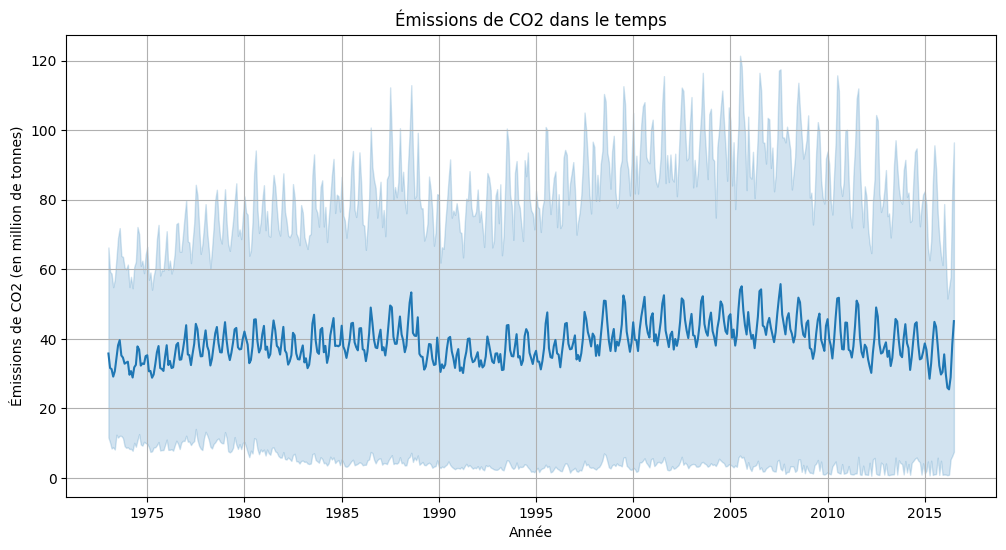

In [13]:
# Affichage graphique
plt.figure(figsize=(12, 6))
sns.lineplot(data=ts, x=ts.index, y='Value')
plt.title("Émissions de CO2 dans le temps")
plt.xlabel("Année")
plt.ylabel("Émissions de CO2 (en million de tonnes)")
plt.grid()
plt.show()

Les émissions de CO2 ont globalement augmenté au fil des années, passant d'environ 25 millions de tonnes en 1975 à près de 175 millions de tonnes en 2015.

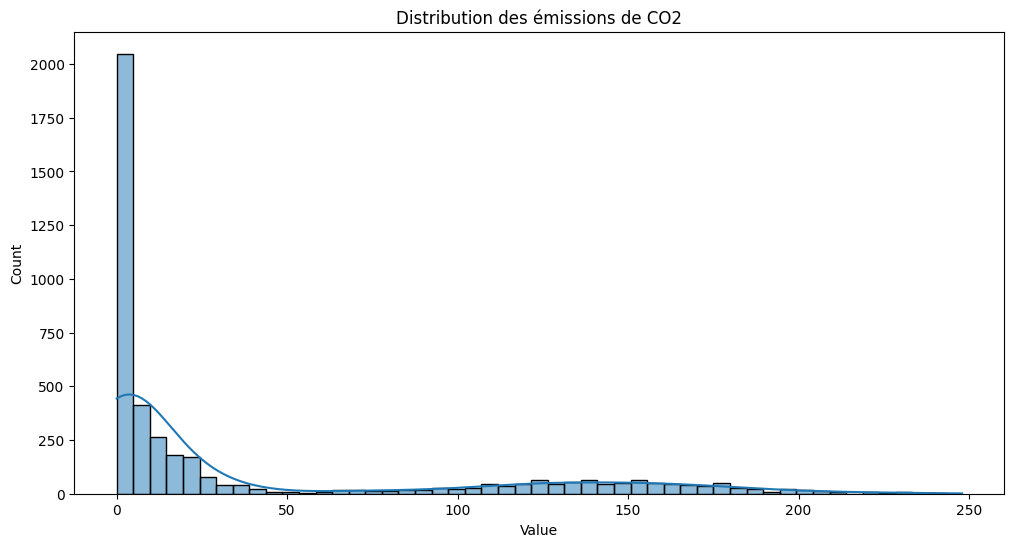

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(ts['Value'], kde=True)
plt.title('Distribution des émissions de CO2')
plt.show()

Nous remarquons que la distribution n’est pas équilibrée

In [15]:
# Grouper les données par type d'émmission
Energy_sources = ts.groupby('Description')
Energy_sources.head(2)

MSN    Value  Column_Order  \
YYYYMM                                       
1973-01-01  CLEIEUS   72.076             1   
1973-02-01  CLEIEUS   64.442             1   
1973-01-01  NNEIEUS   12.175             2   
1973-02-01  NNEIEUS   11.708             2   
1973-01-01  DKEIEUS    2.375             3   
1973-02-01  DKEIEUS    2.061             3   
1973-01-01  PCEIEUS    0.128             4   
1973-02-01  PCEIEUS    0.106             4   
1973-01-01  RFEIEUS   24.867             5   
1973-02-01  RFEIEUS   20.867             5   
1973-01-01  PAEIEUS   27.369             6   
1973-02-01  PAEIEUS   23.034             6   
1989-01-01  GEEIEUS    0.031             7   
1989-02-01  GEEIEUS    0.028             7   
1989-01-01  NWEIEUS    0.371             8   
1989-02-01  NWEIEUS    0.335             8   
1973-01-01  TXEIEUS  111.621             9   
1973-02-01  TXEIEUS   99.185             9   

                                                  Description  \
YYYYMM                                                          
1973-01-01           Coal Electric Power Sector CO2 Emissions   
1973-02-01           Coal Electric Power Sector CO2 Emissions   
1973-01-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-02-01    Natural Gas Electric Power Sector CO2 Emissions   
1973-01-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-02-01  Distillate Fuel, Including Kerosene-Type Jet F...   
1973-01-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-02-01  Petroleum Coke Electric Power Sector CO2 Emiss...   
1973-01-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-02-01  Residual Fuel Oil Electric Power Sector CO2 Em...   
1973-01-01      Petroleum Electric Power Sector CO2 Emissions   
1973-02-01      Petroleum Electric Power Sector CO2 Emissions   
1989-01-01  Geothermal Energy Electric Power Sector CO2 Em...   
1989-02-01  Geothermal Energy Electric Power Sector CO2 Em...   
1989-01-01  Non-Biomass Waste Electric Power Sector CO2 Em...   
1989-02-01  Non-Biomass Waste Electric Power Sector CO2 Em...   
1973-01-01   Total Energy Electric Power Sector CO2 Emissions   
1973-02-01   Total Energy Electric Power Sector CO2 Emissions   

                                             Unit  msn_encoded  
YYYYMM                                                          
1973-01-01  Million Metric Tons of Carbon Dioxide            0  
1973-02-01  Million Metric Tons of Carbon Dioxide            0  
1973-01-01  Million Metric Tons of Carbon Dioxide            3  
1973-02-01  Million Metric Tons of Carbon Dioxide            3  
1973-01-01  Million Metric Tons of Carbon Dioxide            1  
1973-02-01  Million Metric Tons of Carbon Dioxide            1  
1973-01-01  Million Metric Tons of Carbon Dioxide            6  
1973-02-01  Million Metric Tons of Carbon Dioxide            6  
1973-01-01  Million Metric Tons of Carbon Dioxide            7  
1973-02-01  Million Metric Tons of Carbon Dioxide            7  
1973-01-01  Million Metric Tons of Carbon Dioxide            5  
1973-02-01  Million Metric Tons of Carbon Dioxide            5  
1989-01-01  Million Metric Tons of Carbon Dioxide            2  
1989-02-01  Million Metric Tons of Carbon Dioxide            2  
1989-01-01  Million Metric Tons of Carbon Dioxide            4  
1989-02-01  Million Metric Tons of Carbon Dioxide            4  
1973-01-01  Million Metric Tons of Carbon Dioxide            8  
1973-02-01  Million Metric Tons of Carbon Dioxide            8

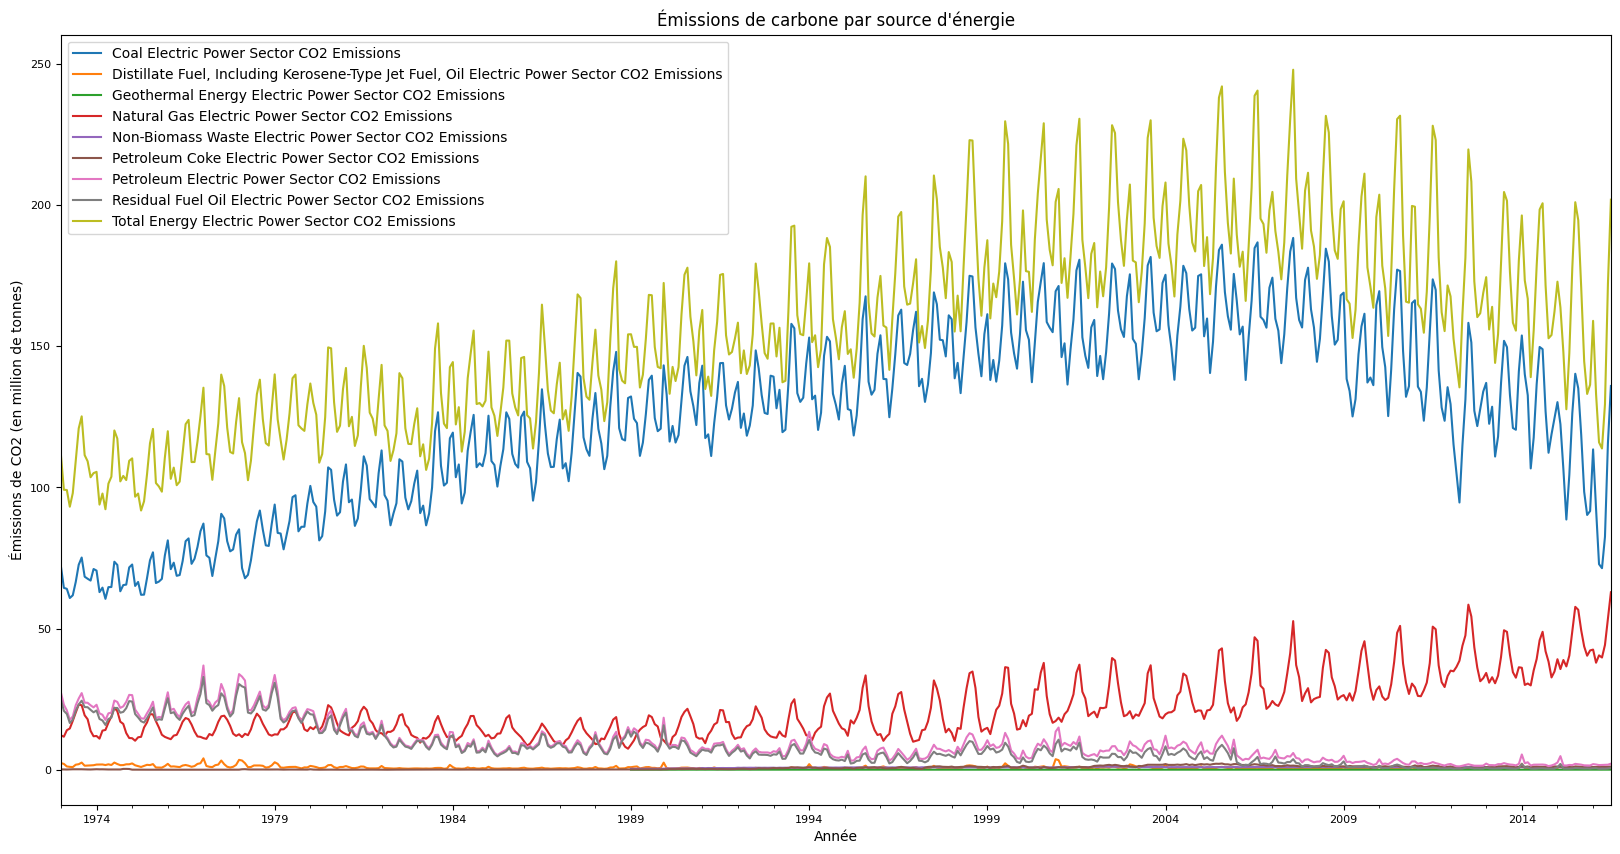

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))

for desc, group in Energy_sources:
    group.plot(
        y='Value', 
        label=desc, 
        ax=ax, 
        title="Émissions de carbone par source d'énergie", 
        fontsize=8
    )

ax.set_xlabel('Année')
ax.set_ylabel('Émissions de CO2 (en million de tonnes)')
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)
ax.legend(fontsize=10)


Nous pouvons visualiser la tendance et l’effet de saisonnalité sur les émissions de CO2 de chaque source d’énergie.

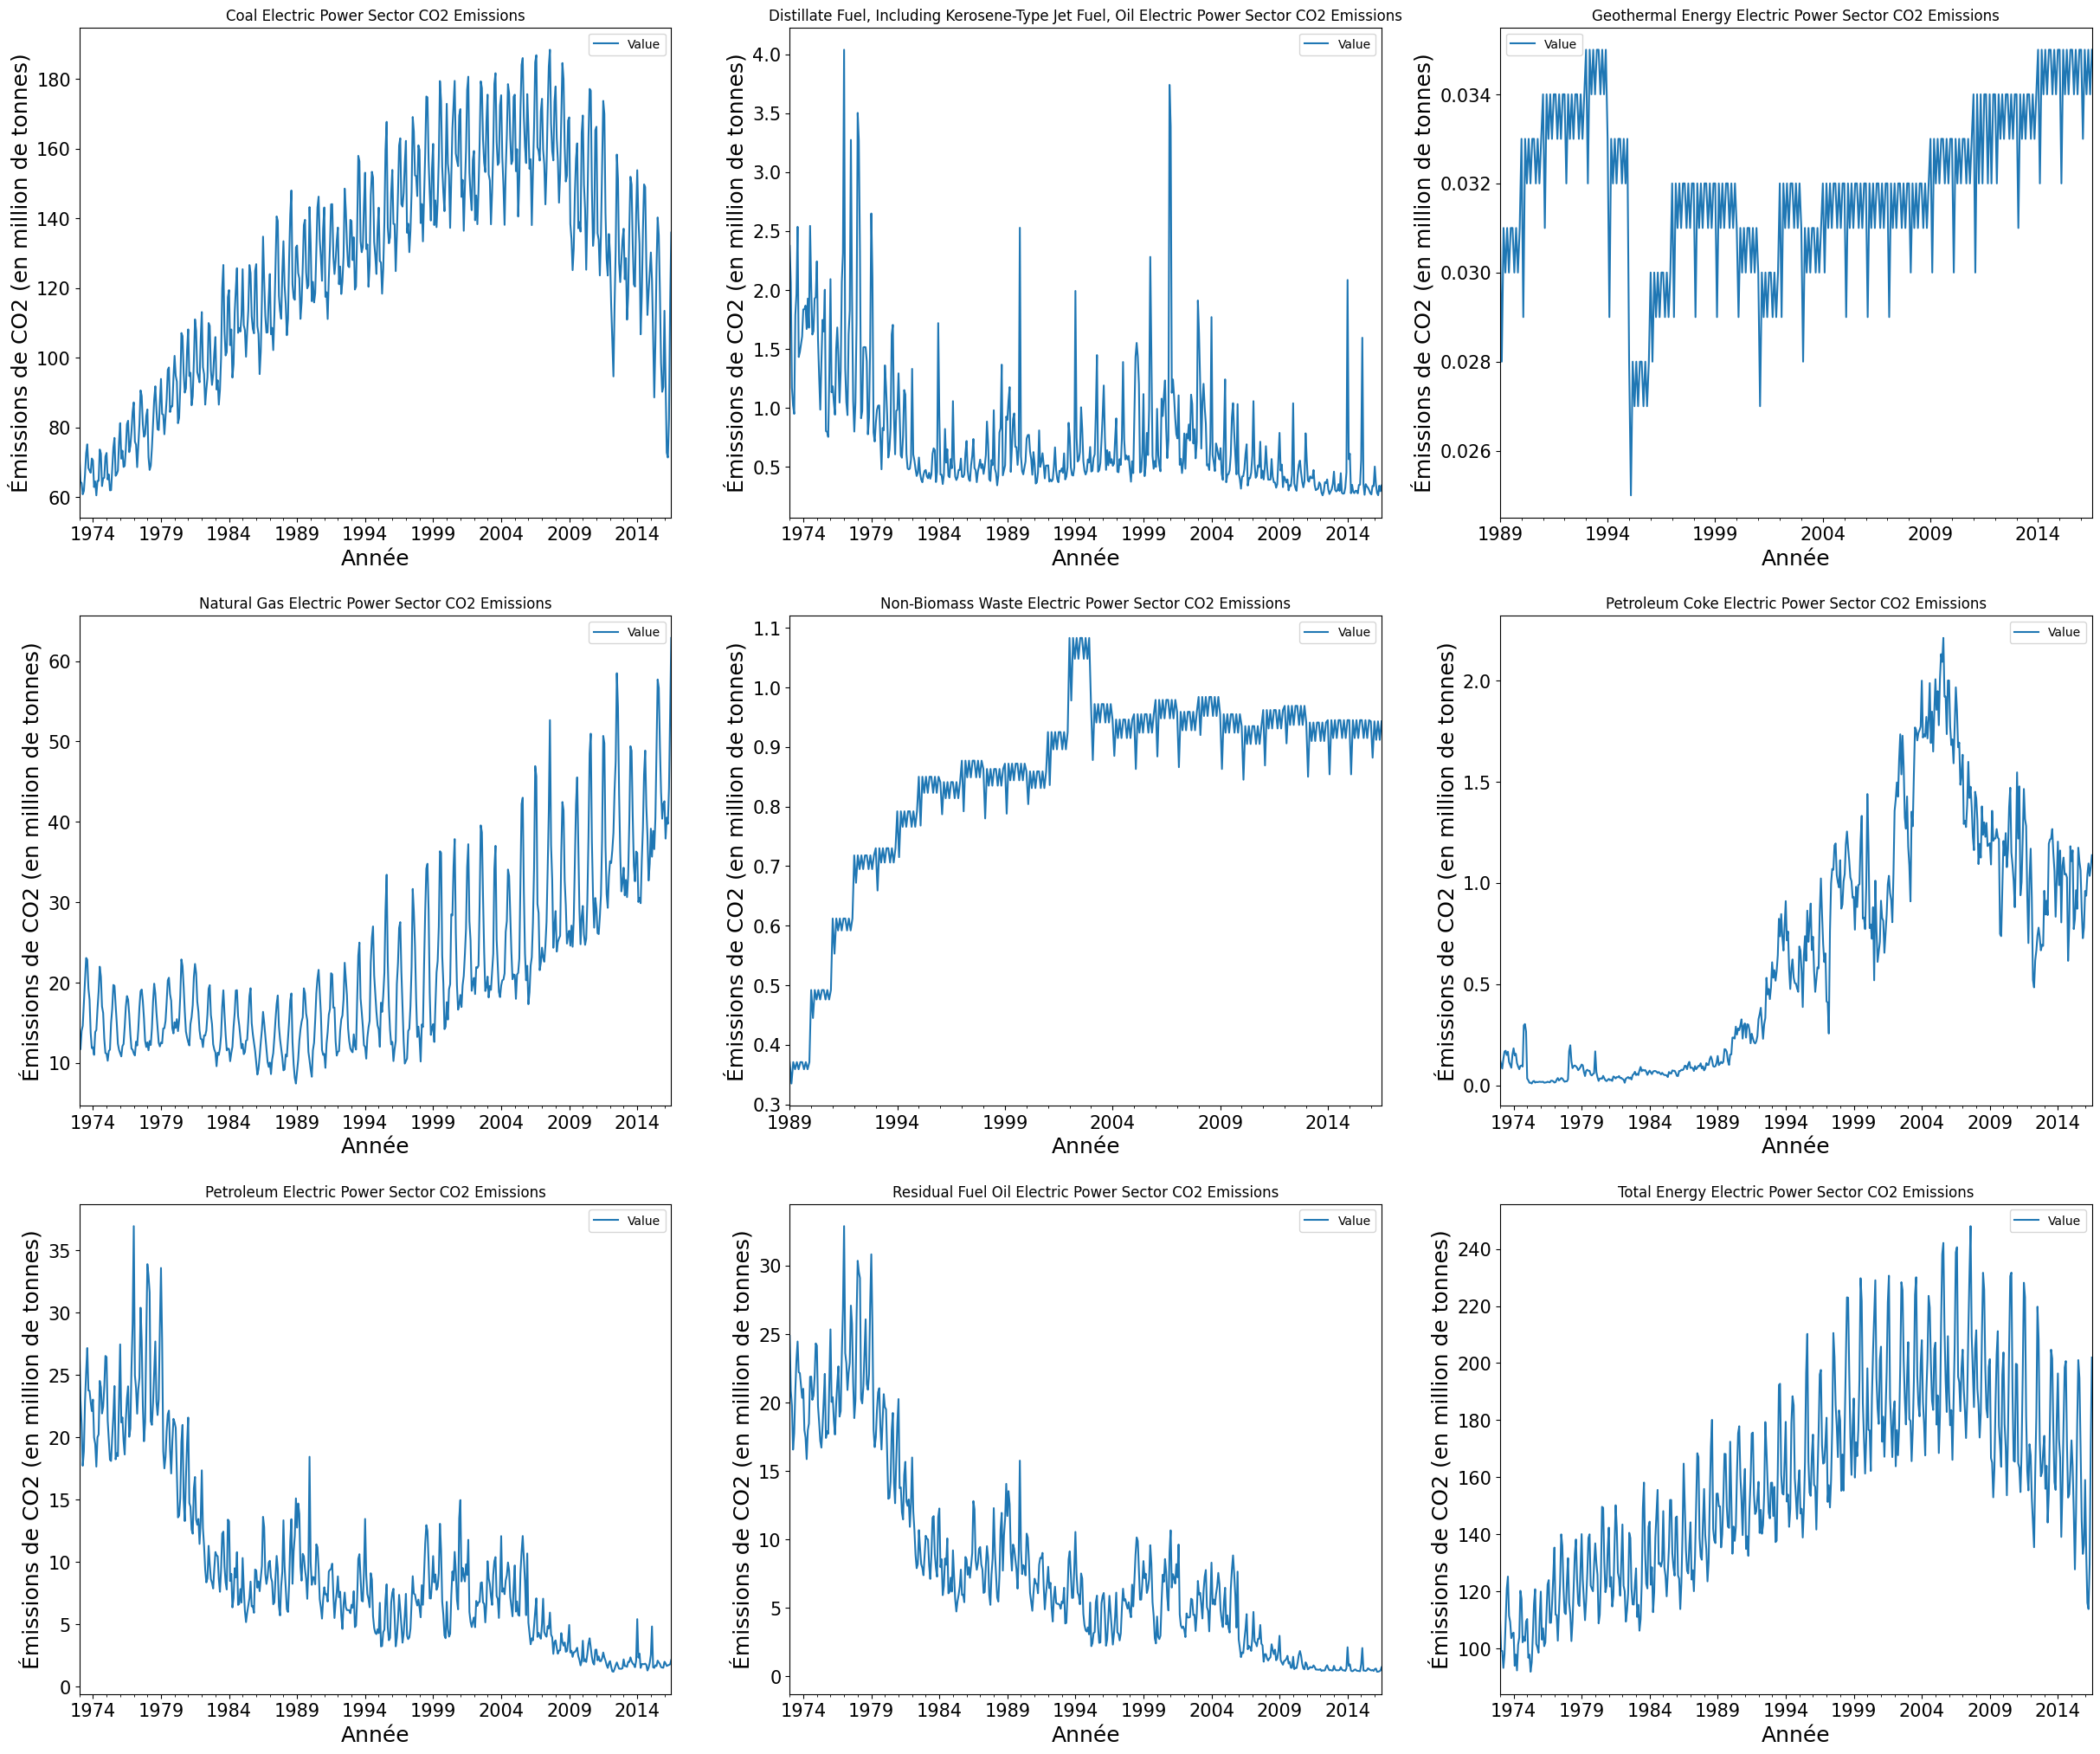

In [17]:
fig, axes = plt.subplots(3,3, figsize = (30, 25))
for (desc, group), ax in zip(Energy_sources, axes.flatten()):
    group.plot( y='Value',ax = ax, title=desc, fontsize = 15)
    ax.set_xlabel('Année')
    ax.set_ylabel('Émissions de CO2 (en million de tonnes)')
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

Ces dernières années, la consommation de gaz naturel a augmenté. Cependant, l'utilisation du charbon pour la production d'électricité a diminué. Les courbes des émissions de CO2 du charbon et du gaz naturel illustrent cette tendance : si la contribution du charbon aux émissions de CO2 diminue, celle du gaz naturel augmente.

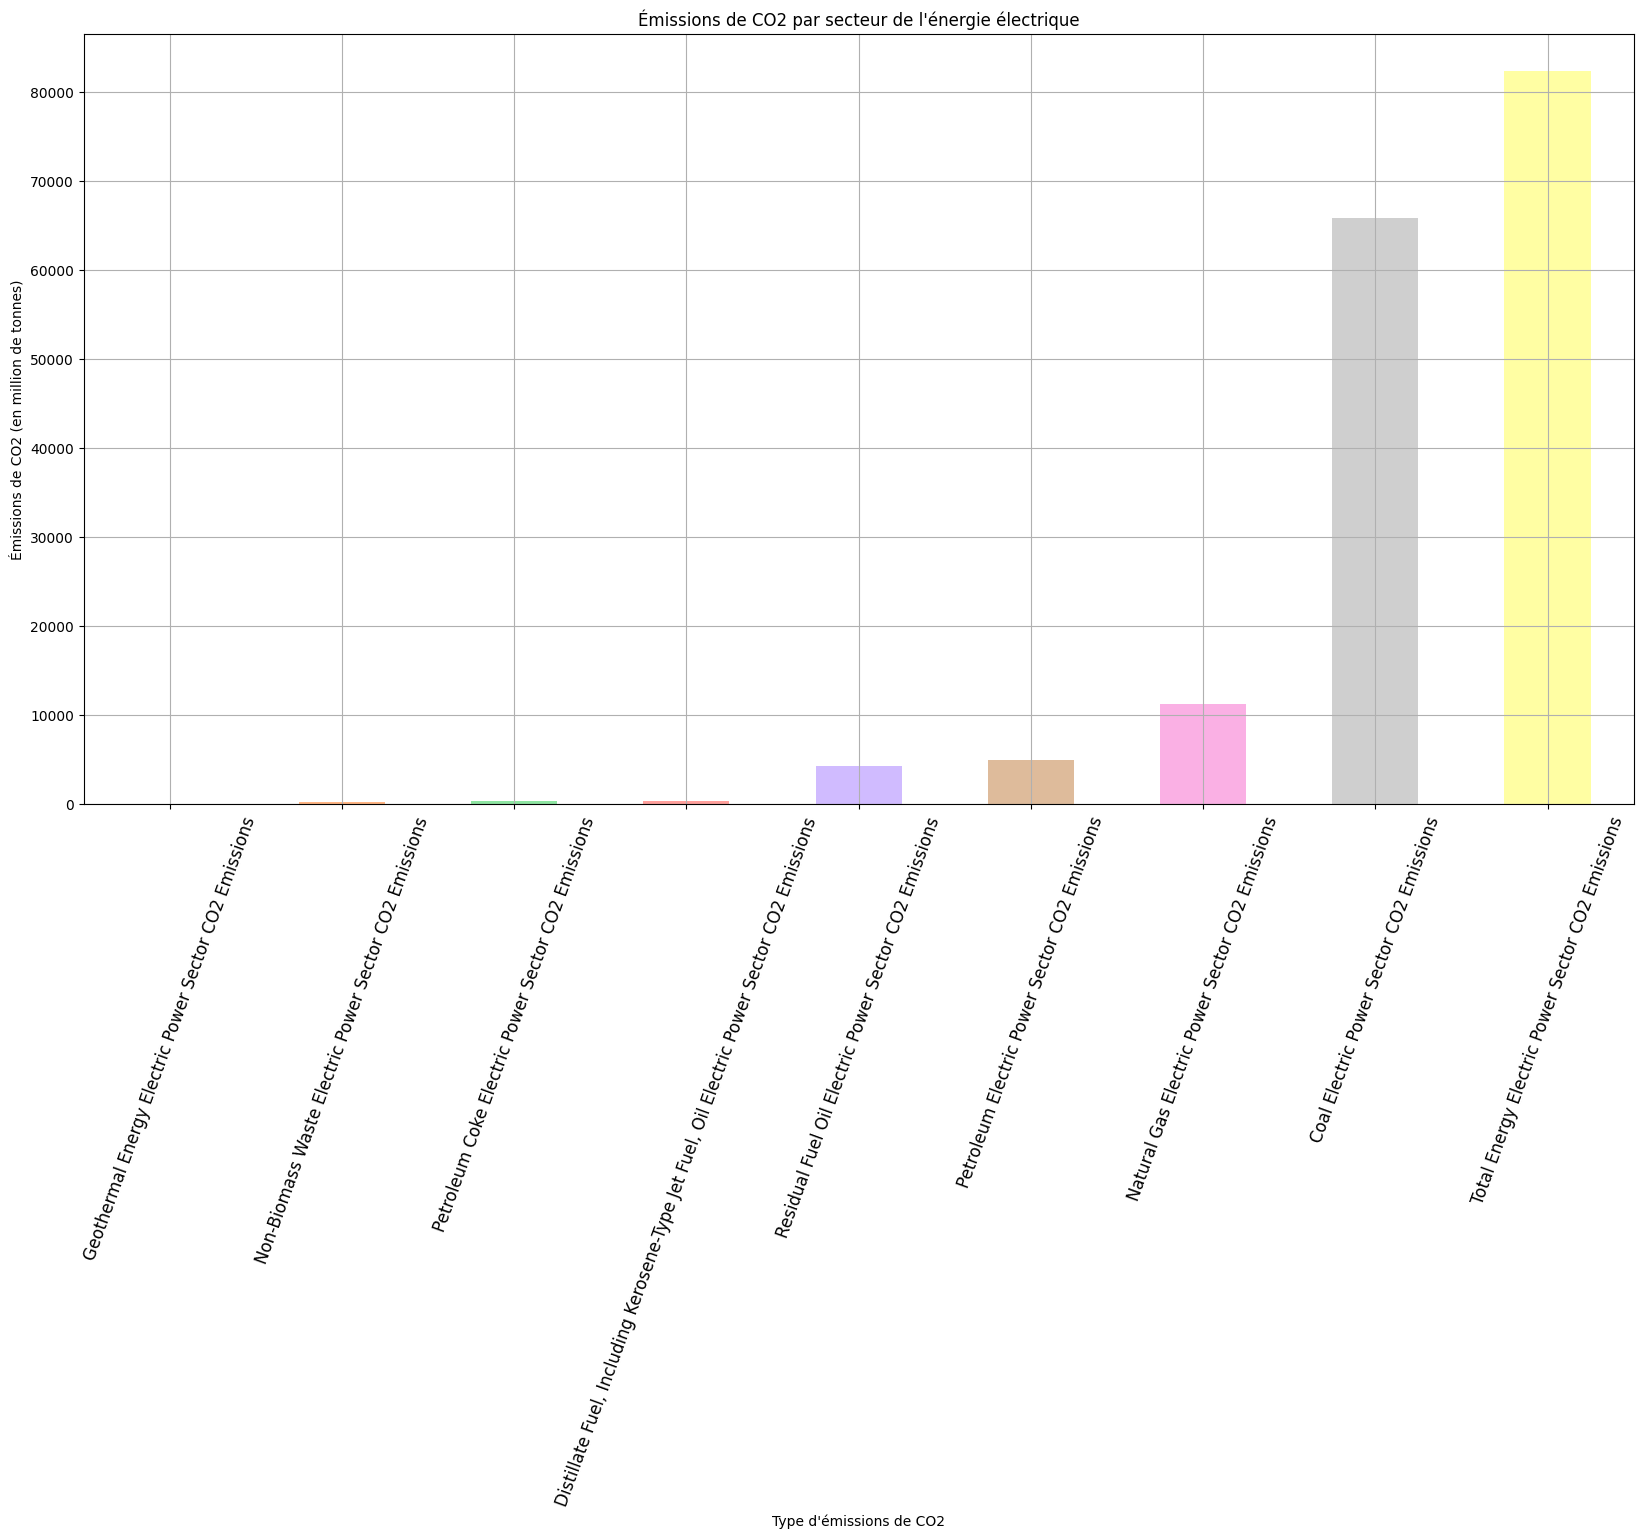

In [18]:
CO2_per_source = ts.groupby('Description')['Value'].sum().sort_values()
# Génération de la palette de couleurs
colors = sns.color_palette("pastel", len(CO2_per_source))

# Création de la figure et de l'axe
plt.figure(figsize=(20, 10))

# Tracé de la ligne
CO2_per_source.plot(kind='bar', color=colors)

# Ajout du titre et des labels
plt.title("Émissions de CO2 par secteur de l'énergie électrique")
plt.xticks(rotation = 70, fontsize = 12)
plt.xlabel("Type d'émissions de CO2")
plt.ylabel('Émissions de CO2 (en million de tonnes)')

# Ajouter une grille pour mieux visualiser
plt.grid(True)

Le graphique montre les émissions de CO2 par types. Les émissions varient de **10 000 à 90 000 millions de tonnes**, avec un ou deux types dominant nettement.

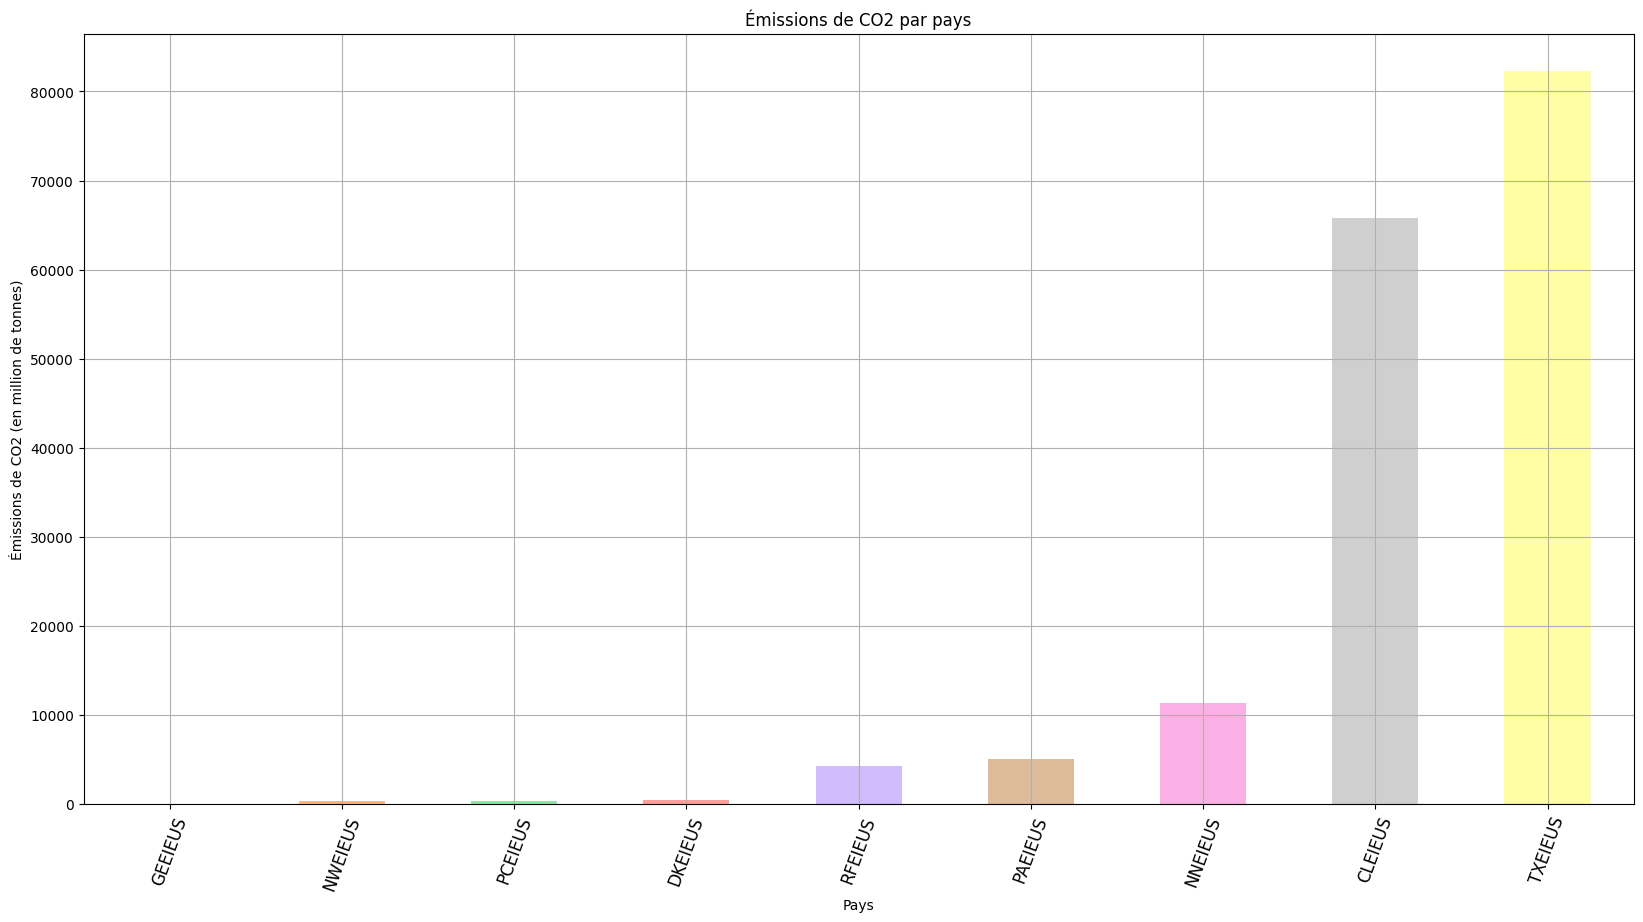

In [19]:
CO2_per_cont = ts.groupby('MSN')['Value'].sum().sort_values()
# Génération de la palette de couleurs
colors = sns.color_palette("pastel", len(CO2_per_cont))

# Création de la figure et de l'axe
plt.figure(figsize=(20, 10))

# Tracé de la ligne
CO2_per_cont.plot(kind='bar', color=colors)

# Ajout du titre et des labels
plt.title("Émissions de CO2 par pays")
plt.xticks(rotation = 70, fontsize = 12)
plt.xlabel("Pays")
plt.ylabel('Émissions de CO2 (en million de tonnes)')

# Ajouter une grille pour mieux visualiser
plt.grid(True)

Le graphique montre les émissions de CO2 par pays. Les émissions varient de **10 000 à 90 000 millions de tonnes**, avec un ou deux pays dominant nettement (Texas & californie).

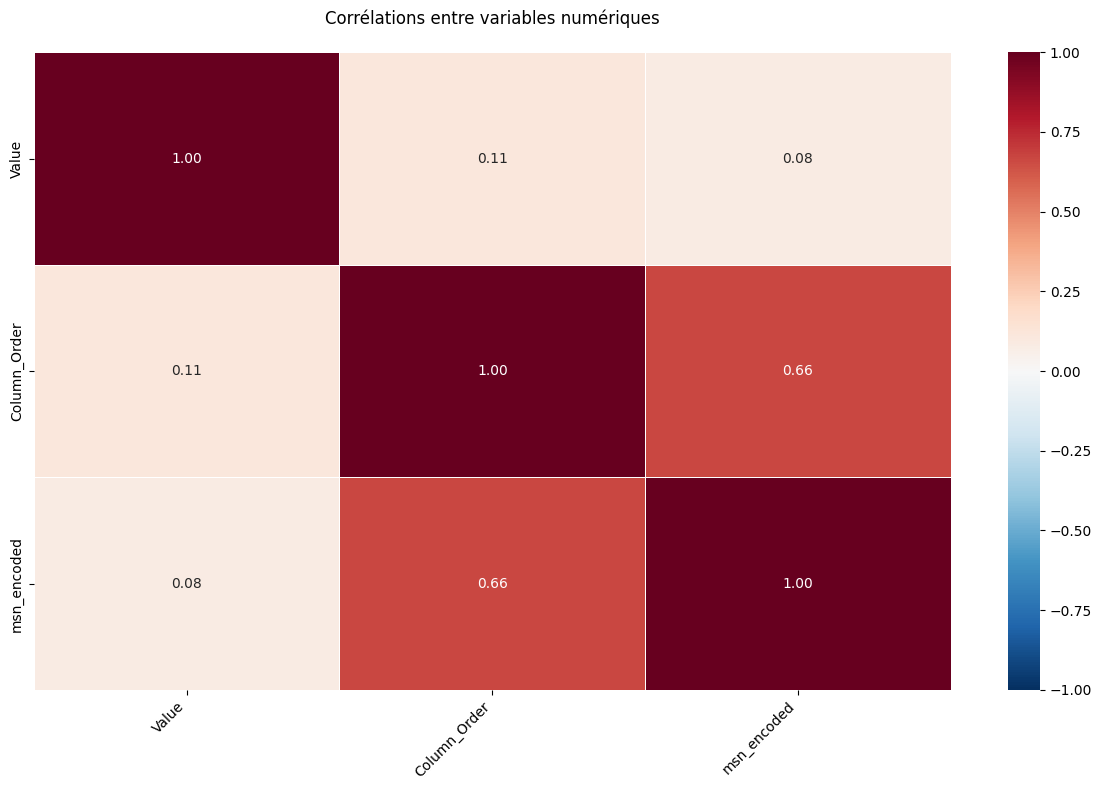

In [20]:
# Sélectionner uniquement les colonnes numériques
numeric_cols = ts.select_dtypes(include=['float64', 'int64']).columns
df_numeric = ts[numeric_cols].dropna()  # Supprimer les NaN

matrix_corr = df_numeric.corr(method='pearson')


# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(matrix_corr,
            cmap='RdBu_r',
            annot=True,
            fmt=".2f",  # Format à 2 décimales
            linewidths=0.5,
            vmin=-1, vmax=1,
            center=0)

plt.title("Corrélations entre variables numériques", pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Le graphique montre des corrélations entre variables numériques, avec des valeurs allant de **-1 à 1**. Les corrélations fortes (>0.8) concernent **Column_order, msn_encoded**, tandis qu'avec **Value** semblent indépendantes (proches de 0). Aucune corrélation négative significative n'est visible.  

De tous les graphiques précédents, nous concluons que la seule colonne qui peut être analysée est **Valeur**, car toutes les autres indiquent uniquement le type d'émission.

In [21]:
# Pivot the table: Rows=Year, Columns=Emission Type, Values=CO2 Value
pivot_table = ts.pivot_table(
    index = ts.index,
    columns='Description', # Emission types (Coal, Oil, Gas)
    values='Value',       # CO2 values
    aggfunc='mean'        # Use mean if duplicates exist
)

pivot_table

Description  Coal Electric Power Sector CO2 Emissions  \
YYYYMM                                                  
1973-01-01                                     72.076   
1973-02-01                                     64.442   
1973-03-01                                     64.084   
1973-04-01                                     60.842   
1973-05-01                                     61.798   
...                                               ...   
2016-03-01                                     72.840   
2016-04-01                                     71.410   
2016-05-01                                     82.510   
2016-06-01                                    115.772   
2016-07-01                                    135.958   

Description  Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions  \
YYYYMM                                                                                                    
1973-01-01                                               2.375                                            
1973-02-01                                               2.061                                            
1973-03-01                                               1.171                                            
1973-04-01                                               1.022                                            
1973-05-01                                               0.949                                            
...                                                        ...                                            
2016-03-01                                               0.279                                            
2016-04-01                                               0.259                                            
2016-05-01                                               0.340                                            
2016-06-01                                               0.293                                            
2016-07-01                                               0.342                                            

Description  Geothermal Energy Electric Power Sector CO2 Emissions  \
YYYYMM                                                               
1973-01-01                                                 NaN       
1973-02-01                                                 NaN       
1973-03-01                                                 NaN       
1973-04-01                                                 NaN       
1973-05-01                                                 NaN       
...                                                        ...       
2016-03-01                                               0.035       
2016-04-01                                               0.034       
2016-05-01                                               0.035       
2016-06-01                                               0.034       
2016-07-01                                               0.035       

Description  Natural Gas Electric Power Sector CO2 Emissions  \
YYYYMM                                                         
1973-01-01                                            12.175   
1973-02-01                                            11.708   
1973-03-01                                            13.994   
1973-04-01                                            14.627   
1973-05-01                                            17.344   
...                                                      ...   
2016-03-01                                            40.525   
2016-04-01                                            39.763   
2016-05-01                                            44.210   
2016-06-01                                            53.567   
2016-07-01                                            62.881   

Description  Non-Biomass Waste Electric Power Sector CO2 Emissions  \
YYYYMM                                              

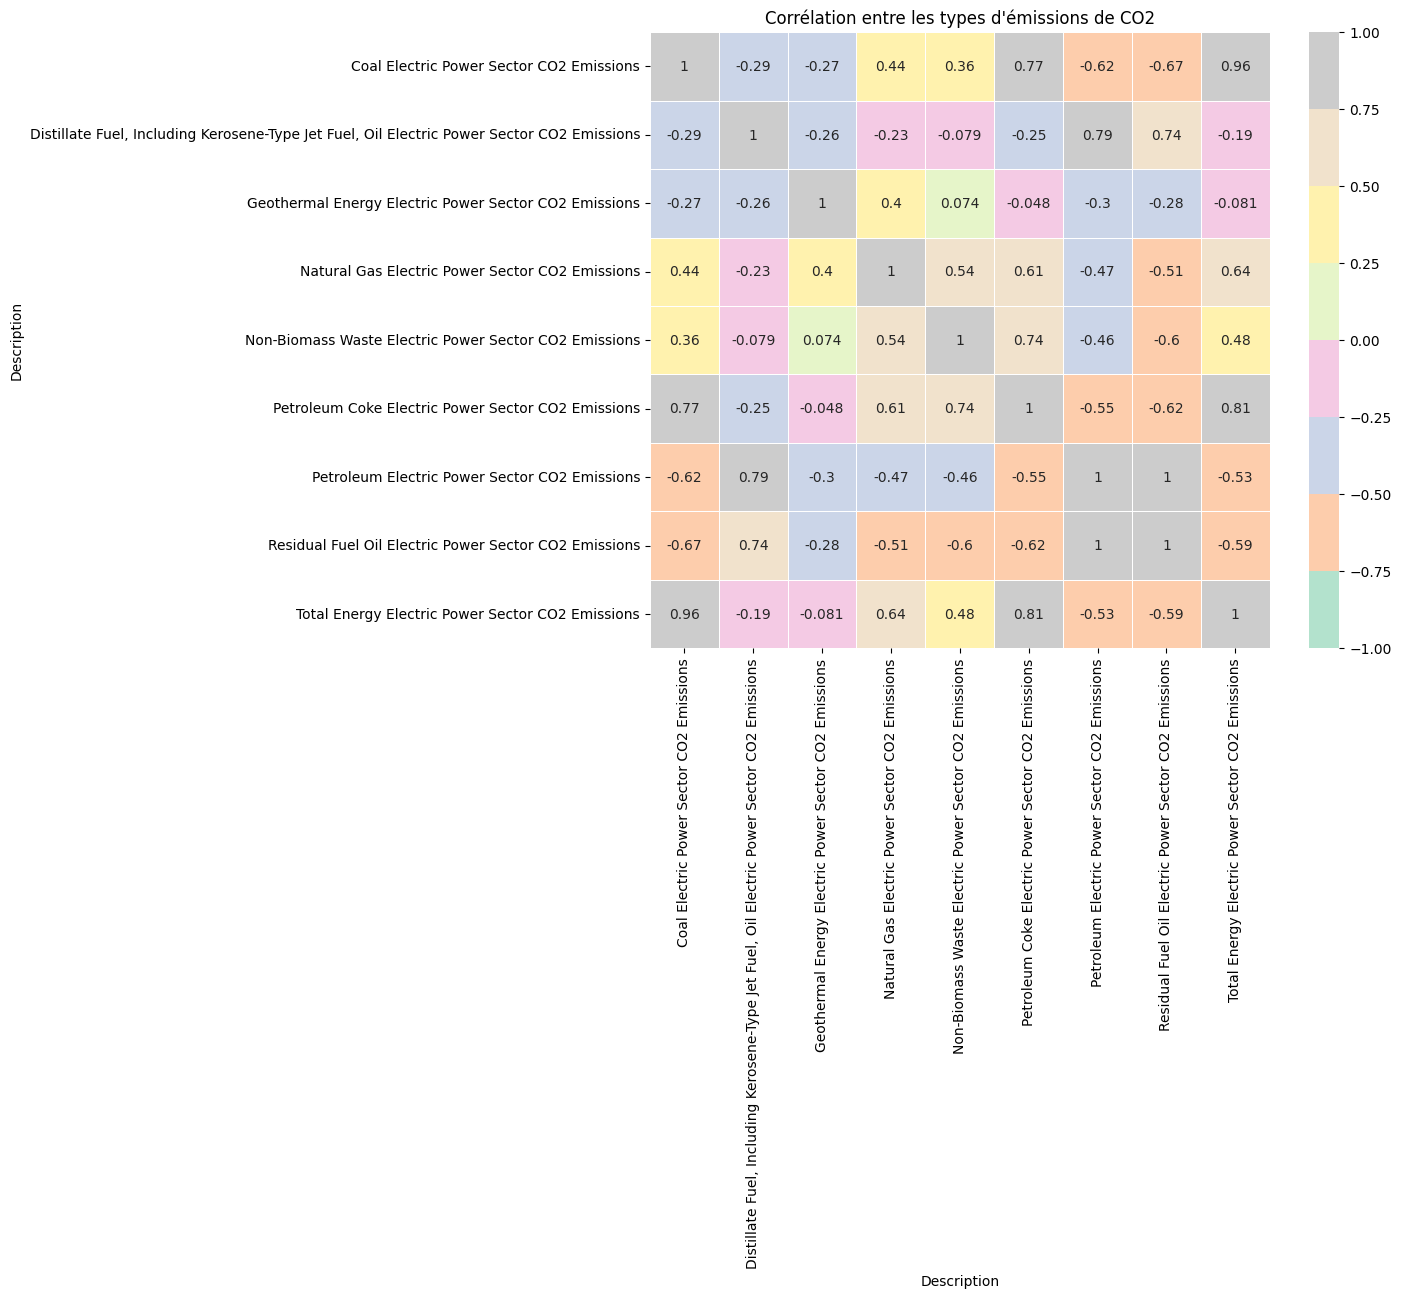

In [22]:
correlation_matrix = pivot_table.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,      # Show correlation values
    cmap='Pastel2',   # Red-Blue color scale
    vmin=-1, vmax=1, # Fix scale from -1 to 1
    linewidths=0.5
)
plt.title("Corrélation entre les types d'émissions de CO2")
plt.show()

Le charbon et le pétrole (coke) sont les principaux drivers des émissions totales. Les renouvelables (géothermie) restent anecdotiques.

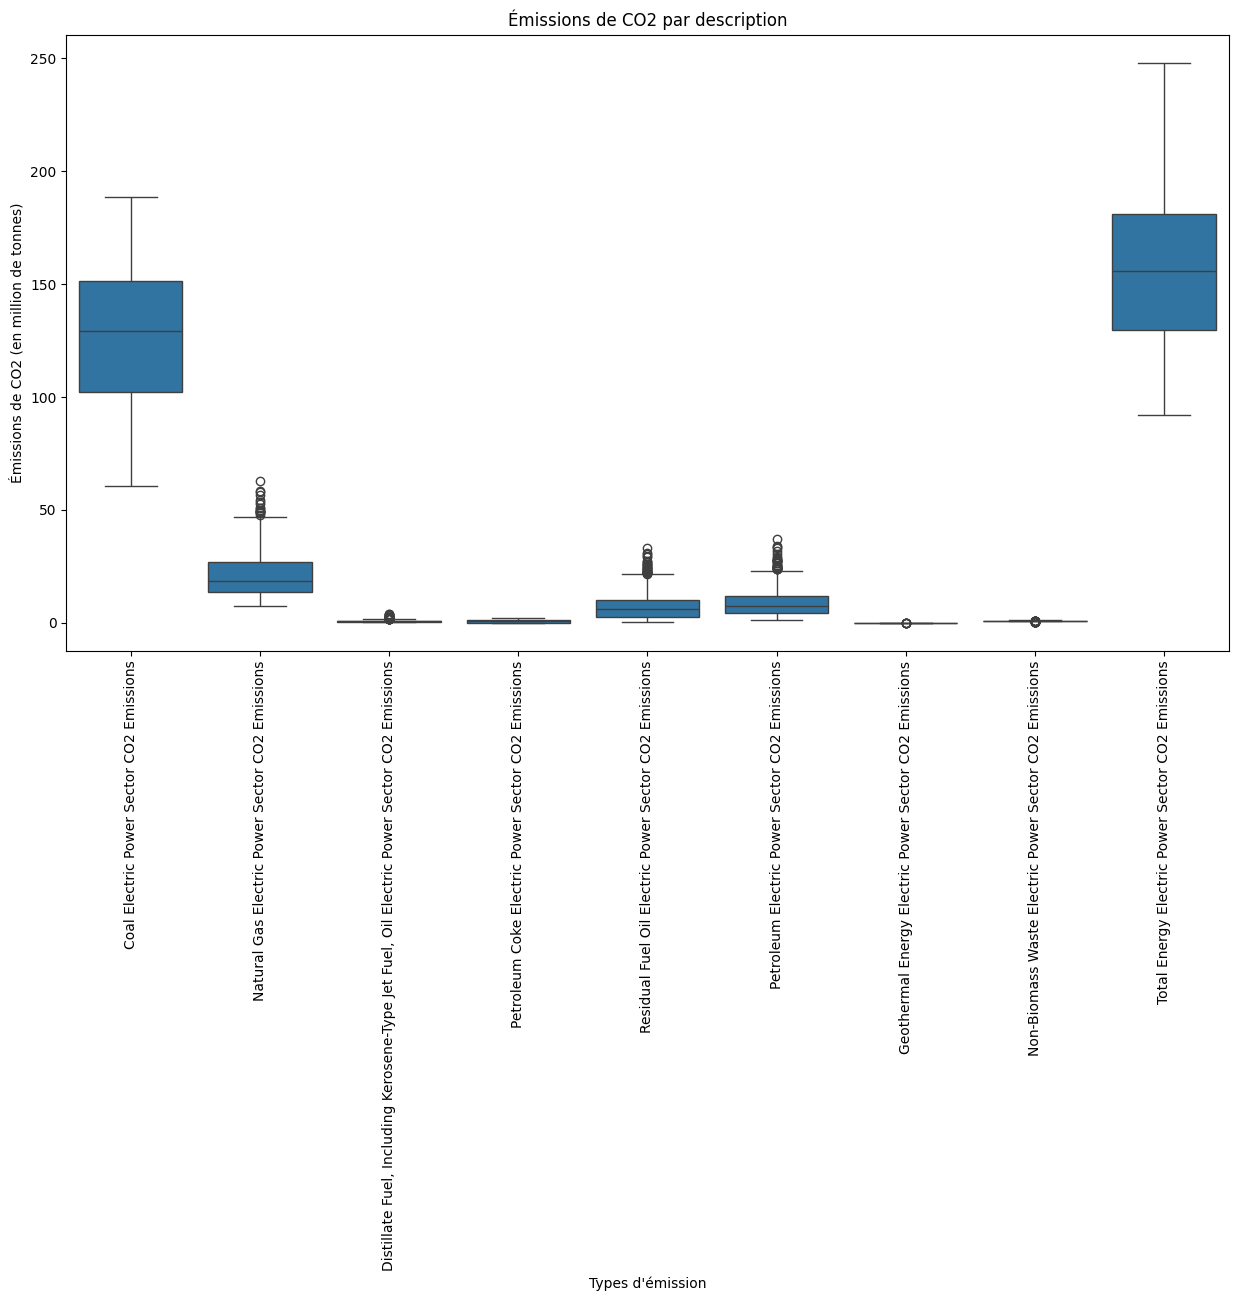

In [23]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='Description', y='Value', data=ts)
plt.xticks(rotation=90)
plt.title('Émissions de CO2 par description')
plt.xlabel("Types d'émission")
plt.ylabel('Émissions de CO2 (en million de tonnes)')
plt.show()

Certains types présentent des valeurs aberrantes que nous devons prendre en considération.

# Prétraitement des données : 

In [72]:
# Description des données
ts.describe()

Value  Column_Order  msn_encoded   Scaled_CO2
count  4323.000000   4323.000000  4323.000000  4323.000000
mean     39.252449      4.777932     4.088827     0.158249
std      61.128676      2.575595     2.659876     0.246501
min       0.009000      1.000000     0.000000     0.000000
25%       0.730000      3.000000     2.000000     0.002907
50%       6.236000      5.000000     4.000000     0.025110
75%      40.638000      7.000000     6.000000     0.163836
max     247.995000      9.000000     8.000000     1.000000

In [73]:
# Normalisation de la colonne value
scaler = MinMaxScaler()
ts["Scaled_CO2"] = scaler.fit_transform(ts[["Value"]])
ts

MSN    Value  Column_Order  \
YYYYMM                                       
1973-01-01  CLEIEUS   72.076             1   
1973-02-01  CLEIEUS   64.442             1   
1973-03-01  CLEIEUS   64.084             1   
1973-04-01  CLEIEUS   60.842             1   
1973-05-01  CLEIEUS   61.798             1   
...             ...      ...           ...   
2016-03-01  TXEIEUS  115.997             9   
2016-04-01  TXEIEUS  113.815             9   
2016-05-01  TXEIEUS  129.440             9   
2016-06-01  TXEIEUS  172.074             9   
2016-07-01  TXEIEUS  201.958             9   

                                                 Description  \
YYYYMM                                                         
1973-01-01          Coal Electric Power Sector CO2 Emissions   
1973-02-01          Coal Electric Power Sector CO2 Emissions   
1973-03-01          Coal Electric Power Sector CO2 Emissions   
1973-04-01          Coal Electric Power Sector CO2 Emissions   
1973-05-01          Coal Electric Power Sector CO2 Emissions   
...                                                      ...   
2016-03-01  Total Energy Electric Power Sector CO2 Emissions   
2016-04-01  Total Energy Electric Power Sector CO2 Emissions   
2016-05-01  Total Energy Electric Power Sector CO2 Emissions   
2016-06-01  Total Energy Electric Power Sector CO2 Emissions   
2016-07-01  Total Energy Electric Power Sector CO2 Emissions   

                                             Unit  msn_encoded  Scaled_CO2  
YYYYMM                                                                      
1973-01-01  Million Metric Tons of Carbon Dioxide            0    0.290609  
1973-02-01  Million Metric Tons of Carbon Dioxide            0    0.259825  
1973-03-01  Million Metric Tons of Carbon Dioxide            0    0.258382  
1973-04-01  Million Metric Tons of Carbon Dioxide            0    0.245308  
1973-05-01  Million Metric Tons of Carbon Dioxide            0    0.249163  
...                                           ...          ...         ...  
2016-03-01  Million Metric Tons of Carbon Dioxide            8    0.467720  
2016-04-01  Million Metric Tons of Carbon Dioxide            8    0.458921  
2016-05-01  Million Metric Tons of Carbon Dioxide            8    0.521929  
2016-06-01  Million Metric Tons of Carbon Dioxide            8    0.693850  
2016-07-01  Million Metric Tons of Carbon Dioxide            8    0.814356  

[4323 rows x 7 columns]

In [74]:
# Creation d'une serie avec les valeurs non normalisée
Emissions = ts.iloc[:, 1:]
Emissions = (
    Emissions
    .groupby(['Description', pd.Grouper(freq='M')])['Value']
    .sum()
    .unstack(level=0)
)

# Choisissez la série d'émissions Natural Gas Electric car elle est en pleine croissance
mte = Emissions['Natural Gas Electric Power Sector CO2 Emissions']
real_mte = mte
mte

YYYYMM
1973-01-31    12.175
1973-02-28    11.708
1973-03-31    13.994
1973-04-30    14.627
1973-05-31    17.344
               ...  
2016-03-31    40.525
2016-04-30    39.763
2016-05-31    44.210
2016-06-30    53.567
2016-07-31    62.881
Freq: ME, Name: Natural Gas Electric Power Sector CO2 Emissions, Length: 523, dtype: float64

In [75]:
# Creation d'une serie avec les valeurs normalisée
Emissions_ = ts.iloc[:, 1:]
Emissions_ = (
    Emissions_
    .groupby(['Description', pd.Grouper(freq='M')])['Scaled_CO2']
    .sum()
    .unstack(level=0)
)

mte_ = Emissions_['Natural Gas Electric Power Sector CO2 Emissions']
mte_

YYYYMM
1973-01-31    0.049059
1973-02-28    0.047176
1973-03-31    0.056394
1973-04-30    0.058947
1973-05-31    0.069903
                ...   
2016-03-31    0.163380
2016-04-30    0.160307
2016-05-31    0.178240
2016-06-30    0.215972
2016-07-31    0.253530
Freq: ME, Name: Natural Gas Electric Power Sector CO2 Emissions, Length: 523, dtype: float64

# Echantillonnage  des  données

In [17]:
# Creation du Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=10)

# Application  des  modèles  d’apprentissage  profond  en  se  basant  sur  les  séries temporelles

## LSTM

In [76]:
# dérivision de la série avec les données normalisée pour
# la création des ensembles de train et de test pour LSTM
train_size_lstm = int(0.7 * len(mte_))
test_size_lstm = len(mte_) - train_size_lstm

train_lstm = mte_.iloc[:train_size_lstm]
test_lstm = mte_.iloc[train_size_lstm:]

In [77]:
# Trouver la dernière date du dataset complet
last_date = pd.concat([train_lstm, test_lstm]).index[-1]

# Créer un index de dates pour l'année suivante (12 mois)
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                            periods=12, 
                            freq='M')

**Création des séquences :**
- Le code crée des séquences de 60 pas de temps (i-60:i) comme entrées (X).
- La valeur suivante (i) est utilisée comme cible (y).

**Conversion en tableaux NumPy :**
- X et y sont convertis en tableaux NumPy pour le traitement efficace par Keras/TensorFlow.

**Remodelage pour LSTM :**
- X est remodelé en 3D : (nombre_échantillons, pas_de_temps, nombre_caractéristiques).

In [78]:
# Préparation des données pour LSTM
X, y = [], []
for i in range(60, len(train_lstm)):
    X.append(train_lstm.values[i-60:i])
    y.append(train_lstm.values[i])
X, y = np.array(X), np.array(y)

# Reshape pour LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))


In [79]:
# Validation croisée pour LSTM
mse_lstm_scores = []
rmse_lstm_scores = []
mae_lstm_scores = []
r2_lstm_scores = []

norm_mse_lstm_scores = []
norm_rmse_lstm_scores = []
norm_mae_lstm_scores = []
norm_r2_lstm_scores = []


for train_index, val_index in tscv.split(X):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]
    
    # Création du modèle LSTM
    model_lstm = Sequential()
    model_lstm.add(LSTM(64, input_shape=(X_train_cv.shape[1], 1)))
    # model_lstm.add(Dropout(0.4)),
    model_lstm.add(Dense(1))
    
    # Compilation et entraînement
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')
    model_lstm.fit(X_train_cv, y_train_cv, epochs=50, batch_size=32, verbose=0)
    
    # Prédictions
    predictions_lstm = model_lstm.predict(X_val_cv)
    predictions_lstm_inverse = scaler.inverse_transform(predictions_lstm)
    y_val_cv_inverse = scaler.inverse_transform(y_val_cv.reshape(-1, 1))

    mse_lstm = mean_squared_error(y_val_cv_inverse, predictions_lstm_inverse)
    mse_lstm_scores.append(mse_lstm)

    norm_mse_lstm = mean_squared_error(y_val_cv, predictions_lstm)
    norm_mse_lstm_scores.append(norm_mse_lstm)

    rmse_lstm = np.sqrt(mse_lstm)
    rmse_lstm_scores.append(rmse_lstm)

    norm_rmse_lstm = np.sqrt(norm_mse_lstm)
    norm_rmse_lstm_scores.append(norm_rmse_lstm)

    mae_lstm = mean_absolute_error(y_val_cv_inverse, predictions_lstm_inverse)
    mae_lstm_scores.append(mae_lstm)

    norm_mae_lstm = mean_absolute_error(y_val_cv, predictions_lstm)
    norm_mae_lstm_scores.append(norm_mae_lstm)

    r2_lstm = r2_score(y_val_cv_inverse, predictions_lstm_inverse)
    r2_lstm_scores.append(r2_lstm)

    norm_r2_lstm = r2_score(y_val_cv, predictions_lstm)
    norm_r2_lstm_scores.append(norm_r2_lstm)

# Affichage des résultats de validation croisée pour LSTM
print(f'Métriques avec les données non normalisée:')

print(f'MSE moyen LSTM: {np.mean(mse_lstm_scores):.4f}')
print(f'RMSE moyen LSTM: {np.mean(rmse_lstm_scores):.4f}')
print(f'MAE moyen LSTM: {np.mean(mae_lstm_scores):.4f}')
print(f'R2 moyen LSTM: {np.mean(r2_lstm_scores):.4f}')

print(f'Métriques avec les données normalisée:')
print(f'MSE moyen LSTM: {np.mean(norm_mse_lstm_scores):.4f}')
print(f'RMSE moyen LSTM: {np.mean(norm_rmse_lstm_scores):.4f}')
print(f'MAE moyen LSTM: {np.mean(norm_mae_lstm_scores):.4f}')
print(f'R2 moyen LSTM: {np.mean(norm_r2_lstm_scores):.4f}')


1/1 [==============================] - 0s 244ms/step
Métriques avec les données non normalisée:
MSE moyen LSTM: 16.7411
RMSE moyen LSTM: 3.9877
MAE moyen LSTM: 3.2130
R2 moyen LSTM: 0.1644
Métriques avec les données normalisée:
MSE moyen LSTM: 0.0003
RMSE moyen LSTM: 0.0161
MAE moyen LSTM: 0.0130
R2 moyen LSTM: 0.1644


In [80]:
# Re-préparer les données de test pour LSTM (en utilisant la même fenêtre glissante de 60 pas de temps)
X_test_final, y_test_final = [], []
for i in range(60, len(test_lstm)):
    X_test_final.append(test_lstm.values[i-60:i])
    y_test_final.append(test_lstm.values[i])
X_test_final, y_test_final = np.array(X_test_final), np.array(y_test_final)

# Reshape pour l'entrée LSTM
X_test_final = X_test_final.reshape((X_test_final.shape[0], X_test_final.shape[1], 1))

# Former le modèle LSTM final
model_lstm_final = Sequential()
model_lstm_final.add(LSTM(64, input_shape=(X.shape[1], 1)))  # X.shape[1] = 60 steps
model_lstm_final.add(Dense(1))
model_lstm_final.compile(optimizer='adam', loss='mean_squared_error')

lstm_par = model_lstm_final.count_params()

# S'adapte sur le train COMPLET (X, y) préparé précédemment
start_train = time.time()
model_lstm_final.fit(X, y, epochs=50, batch_size=32, verbose=0)
end_train = time.time()
training_time_lstm = end_train - start_train

# Prédire sur l'ensemble de test
start_inference = time.time()
predictions_lstm_final = model_lstm_final.predict(X_test_final)
end_inference = time.time()
inference_time_lstm = end_inference - start_inference

# Mise à l'échelle inverse
predictions_lstm_final_inverse = scaler.inverse_transform(predictions_lstm_final)
y_test_final_inverse = scaler.inverse_transform(y_test_final.reshape(-1, 1))

# Evaluation
mse_test_lstm = mean_squared_error(y_test_final_inverse, predictions_lstm_final_inverse)
rmse_test_lstm = np.sqrt(mean_squared_error(y_test_final_inverse, predictions_lstm_final_inverse))
mae_test_lstm = mean_absolute_error(y_test_final_inverse, predictions_lstm_final_inverse)
r2_test_lstm = r2_score(y_test_final_inverse, predictions_lstm_final_inverse)

norm_mse_test_lstm = mean_squared_error(y_test_final, predictions_lstm_final)
norm_rmse_test_lstm = np.sqrt(mean_squared_error(y_test_final, predictions_lstm_final))
norm_mae_test_lstm = mean_absolute_error(y_test_final, predictions_lstm_final)
norm_r2_test_lstm = r2_score(y_test_final, predictions_lstm_final)

# Préparation des données pour la prévision
# Nous avons besoin des 60 dernières valeurs pour faire la première prédiction
last_60 = test_lstm.values[-60:].reshape(1, 60, 1)  # Format (1, 60, 1) pour LSTM

# Boucle de prévision
forecasts = []
for _ in range(12):  # Prévision pour 12 mois
    # Prédire le prochain pas de temps
    next_pred = model_lstm_final.predict(last_60, verbose=0)
    forecasts.append(next_pred[0,0])
    
    # Mettre à jour la fenêtre glissante
    last_60 = np.roll(last_60, -1, axis=1)
    last_60[0, -1, 0] = next_pred[0,0]


# Mise à l'échelle inverse
forecasts = np.array(forecasts).reshape(-1, 1)
forecasts_inverse = scaler.inverse_transform(forecasts)

print(f'Métriques avec les données normalisée:')
print(f'LSTM - MSE Test: {norm_mse_test_lstm:.4f}, RMSE Test: {norm_rmse_test_lstm}, MAE Test: {norm_mae_test_lstm:.4f}, R² Test: {norm_r2_test_lstm:.4f}')
print(f'Métriques avec les données non normalisée:')
print(f'LSTM - MSE Test: {mse_test_lstm:.4f}, RMSE Test: {rmse_test_lstm}, MAE Test: {mae_test_lstm:.4f}, R² Test: {r2_test_lstm:.4f}, Training Time: {training_time_lstm}, Inference Time: {inference_time_lstm}, Parameters: {lstm_par}')


4/4 [==============================] - 0s 6ms/step
Métriques avec les données normalisée:
LSTM - MSE Test: 0.0005, RMSE Test: 0.022338014097325783, MAE Test: 0.0188, R² Test: 0.6004
Métriques avec les données non normalisée:
LSTM - MSE Test: 30.6862, RMSE Test: 5.539514891772627, MAE Test: 4.6601, R² Test: 0.6004, Training Time: 9.620487928390503, Inference Time: 0.2704026699066162, Parameters: 16961


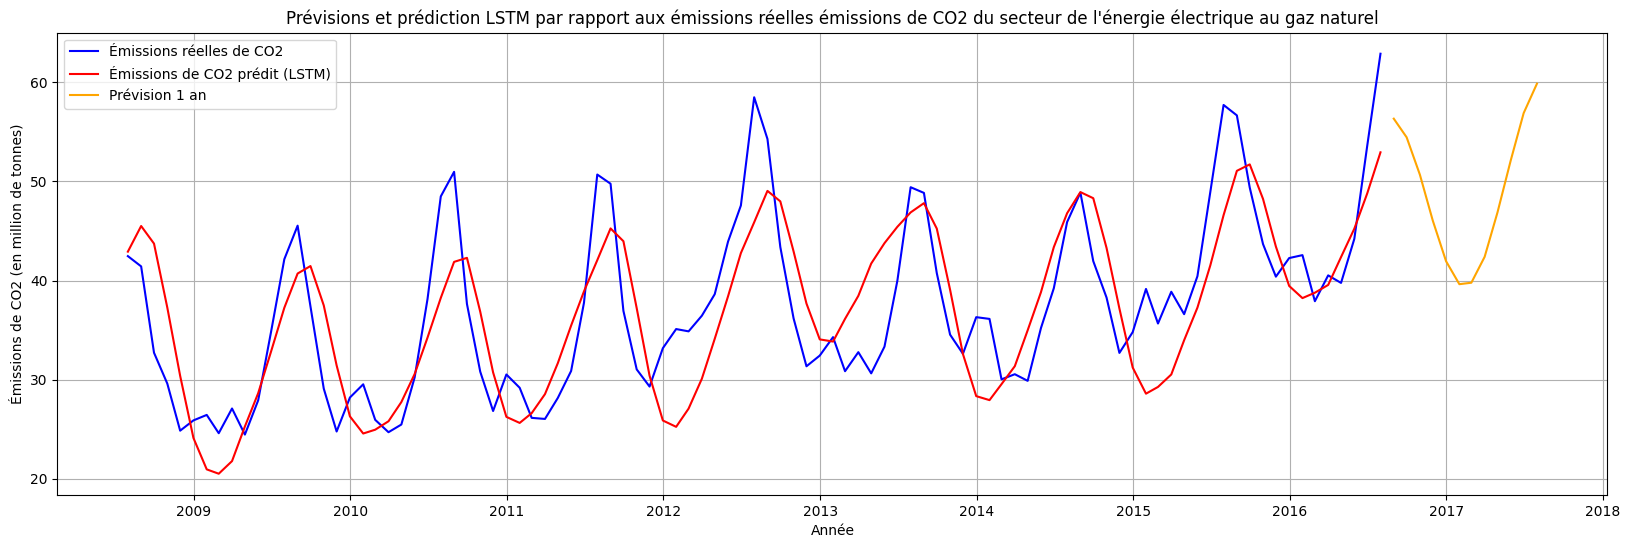

In [81]:
test_index = test_lstm.index[60:]

# Plot
plt.figure(figsize=(20, 6))
plt.plot(test_index, y_test_final_inverse, label="Émissions réelles de CO2", color='blue')
plt.plot(test_index, predictions_lstm_final_inverse, label="Émissions de CO2 prédit (LSTM)", color='red')
plt.plot(future_dates, forecasts_inverse, label='Prévision 1 an', color='orange')
plt.legend()
plt.title("Prévisions et prédiction LSTM par rapport aux émissions réelles émissions de CO2 du secteur de l'énergie électrique au gaz naturel")
plt.xlabel("Année")
plt.ylabel("Émissions de CO2 (en million de tonnes)")
plt.grid(True)
plt.show()

## Transformer

In [18]:
train = mte[mte.index.year < 2010]
test = mte[mte.index.year >= 2010]

# Mettre à l'échelle la série
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train.values.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test.values.reshape(-1, 1)).flatten()

In [19]:
# Définition de la taille de la séquence temporelle (12 mois = 1 an)
SEQUENCE_SIZE = 12  # On utilise 1 an de données mensuelles comme contexte historique

def to_sequences(seq_size, obs):
    """Convertit une série temporelle en séquences pour un Transformer.
    
    Args:
        seq_size: Longueur de la séquence d'entrée
        obs: Série temporelle normalisée (array numpy)
    
    Returns:
        Tuple (séquences d'entrée, valeurs cibles) adapté aux Transformers
    """
    x, y = [], [] # Initialisation des listes pour les entrées et sorties

    # Création des séquences par fenêtrage glissant
    for i in range(len(obs) - seq_size):
        # Fenêtre courante de seq_size points (12 mois)
        window = obs[i:(i + seq_size)]
        # Point suivant à prédire
        after_window = obs[i + seq_size]
        # Ajout de la séquence d'entrée
        x.append(window)
        # Ajout de la valeur cible
        y.append(after_window)

    # Conversion en tenseurs PyTorch et reshape
    # x.shape = (nombre_séquences, seq_size, 1) [3D nécessaire pour les réseaux de neuronnes]
    # y.shape = (nombre_séquences, 1)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Préparation des données d'entraînement et de test
x_train, y_train = to_sequences(SEQUENCE_SIZE, train_scaled)
x_test, y_test = to_sequences(SEQUENCE_SIZE, test_scaled)

# Création des DataLoaders pour l'entraînement par batch
train_dataset = TensorDataset(x_train, y_train)
# Traite 32 séquences simultanément
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**Fenêtrage temporel :**
- La fonction to_sequences découpe la série temporelle en fenêtres de 12 mois (SEQUENCE_SIZE)
- Pour chaque fenêtre de 12 mois (ex: Jan-Dec 2000), on prédit le mois suivant (Jan 2001)

**DataLoaders :**
- Permettent de charger les données par batch pendant l'entraînement
- shuffle=True mélange les séquences d'entraînement pour éviter des biais
- Batch size=32 signifie que le modèle voit 32 séquences simultanément

In [20]:
# Transformer Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
                
        # Initialisation d'un tenseur vide pour stocker les encodages positionnels
        pe = torch.zeros(max_len, d_model)

        # Création d'un vecteur de positions [0, 1, 2, ..., max_len-1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Terme diviseur pour le calcul des fréquences (formule originale du Transformer)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        # Application des fonctions sin/cos alternées sur les dimensions
        pe[:, 0::2] = torch.sin(position * div_term) # Cases paires
        pe[:, 1::2] = torch.cos(position * div_term) # Cases impaires

        # Reshape pour compatibilité avec l'architecture Transformer
        pe = pe.unsqueeze(0).transpose(0, 1)
        # Enregistrement comme buffer (non paramètre apprenable)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Ajout des encodages positionnels aux embeddings d'entrée
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

**Fonction :**
- Ajoute des informations de position aux embeddings token pour préserver la notion d'ordre temporel

**Explications techniques :**
1. Initialisation :
   - `d_model` : dimension des embeddings
   - `max_len` : longueur maximale des séquences supportées
   - `dropout` : taux de régularisation

2. Calcul des encodages :
   - Utilise des fonctions sinusoïdales de fréquences variables (via div_term)
      - On crée des ondes radio de différentes fréquences :
         - Basses fréquences → Positions proches
         - Hautes fréquences → Positions lointaines
      -  Les grands nombres perturbent l'apprentissage. Les sin/cos gardent les valeurs entre [-1, 1].
   - Alternance sin/cos sur les dimensions voisines
   - Échelle logarithmique pour gérer différentes longueurs de séquence

3. Mécanisme forward :
   - Ajout simple des encodages aux embeddings
   - Application de dropout pour éviter le surapprentissage

**Pourquoi :**
- Les Transformers n'ont pas de notion innée d'ordre (contrairement aux RNN) => C'est comme ajouter des étiquettes invisibles à chaque mot d'une phrase pour que l'ordinateur comprenne l'ordre des mots.
- Permet au modèle de distinguer les tokens selon leur position
- Combinaison sin/cos permet d'extrapoler à des longueurs non vues
- Le dropout ici régularise spécifiquement les composantes positionnelles
- L'échelle logarithmique (10000.0) est un hyperparamètre clé de l'architecture originale


In [21]:
class CO2Transformer(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=3, dropout=0.4):
        super(CO2Transformer, self).__init__()

        # Transforme chaque valeur scalaire de la série temporelle en un vecteur de dimension d_model.
        self.encoder = nn.Linear(input_dim, d_model)
        # Ajoute des informations de position pour conserver l'ordre temporel.
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Réduit la représentation vectorielle complexe à une prédiction scalaire
        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
            )
        """
        Utilise uniquement le dernier vecteur de la séquence (à la position -1) :
        - Contient l'information condensée de toute l'histoire temporelle
        - Le décodage final le transforme en une prédiction unique
        """
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = self.encoder(x)  # (batch_size, seq_len, d_model)
        """
        Projette chaque valeur scalaire dans un espace de dimension d_model.
        Ex : Une séquence de 12 valeurs devient 12 vecteurs de taille 64.
        """
        
        # Positional encoding expects (seq_len, batch_size, d_model)
        x = x.permute(1, 0, 2)  # Change to (seq_len, batch_size, d_model)
        """
        Réorganise les dimensions pour compatibilité avec PositionalEncoding.
        PositionalEncoding attend traditionnellement (seq_len, batch_size, d_model).
        """
        x = self.pos_encoder(x)
        """
        Injecte l'information de position dans chaque vecteur.
        Chaque position dans la séquence reçoit une "signature" unique.
        """
        
        # Traitement par le Transformer 
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, d_model)
        """
        Remet les données dans le format attendu par nn.TransformerEncoder
        lorsque batch_first=True.
        """
        x = self.transformer_encoder(x)
        
        # Prédiction finale
        x = self.decoder(x[:, -1, :])  # (batch_size, 1)
        return x

**Cœur du modèle :**
- nhead : Nombre de têtes d'attention (4 mécanismes d'attention parallèles)
- num_layers : Nombre de couches empilées (3 couches de traitement)
- dropout : Régularisation pour éviter le surapprentissage

**Le Transformer :**
1. Analyse les relations entre toutes les positions (mécanisme d'attention)
2. Combine ces informations à travers plusieurs couches
3. Produit une nouvelle représentation enrichie de la séquence

**Pourquoi :**
- Encodage initial : Permet au modèle de travailler dans un espace riche en informations
- PositionalEncoding : Indispensable pour les séries temporelles
- Attention multi-têtes : Capture différents types de dépendances temporelles
- Décodage sur la dernière position : Naturel pour la prédiction un pas en avant

In [22]:
# Configuration de la formation
model = CO2Transformer().to(device)
"""
Crée une instance du modèle CO2Transformer et le déplace sur le device (GPU/CPU).
Le modèle contient :
- Un encodeur linéaire
- Un positional encoding
- Des couches Transformer
- Un décodeur final
"""

# Définition de la fonction de perte
criterion = nn.MSELoss()

# Configuration de l'optimiseur
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
"""
AdamW (Adam avec décroissance de poids) :
- lr=0.001 : Taux d'apprentissage initial
- weight_decay=1e-5 : Régularisation L2 pour éviter le surapprentissage
Avantages :
- Adapte les taux d'apprentissage par paramètre
- Gère bien les gradients bruyants
"""

# Configuration du scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
"""
Adapte dynamiquement le taux d'apprentissage :
- 'min' : Surveille la diminution de la perte
- patience=5 : Nombre d'epochs sans amélioration avant réduction
- factor=0.5 : Réduit le lr de moitié quand plateau détecté
But : Affiner l'apprentissage en cours d'entraînement
"""

"\nAdapte dynamiquement le taux d'apprentissage :\n- 'min' : Surveille la diminution de la perte\n- patience=5 : Nombre d'epochs sans amélioration avant réduction\n- factor=0.5 : Réduit le lr de moitié quand plateau détecté\nBut : Affiner l'apprentissage en cours d'entraînement\n"

**Pourquoi :**
- AdamW est le meilleur compromis vitesse/précision
- MSE est naturelle pour prédire des valeurs continues
- Scheduler évite de rester bloqué dans des minima locaux
- weight_decay aide contre le surapprentissage sans être trop agressif

**Déroullement :**
- Forward pass : Le modèle fait sa prédiction
- Calcul de la MSE entre prédiction et vérité terrain
- Backward pass : Calcul des gradients
- Mise à jour des poids par AdamW
- Toutes les 5 epochs sans amélioration, réduction du learning rate

In [23]:
# Training Loop
epochs = 200 # Nombre maximum d'itérations sur le dataset complet
best_val_loss = float('inf') # Initialise la meilleure loss de validation à +infini
early_stop_counter = 0         # Compteur pour le critère d'arrêt anticipé
patience = 10                  # Nombre d'epochs sans amélioration avant arrêt

# Boucle d'entraînement principale
for epoch in range(epochs):
    model.train()
    train_loss = 0

    # Parcours des batchs d'entraînement
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device) # Transfert sur GPU si disponible
        
        optimizer.zero_grad() # Réinitialisation des gradients
        outputs = model(x_batch) # Forward pass
        loss = criterion(outputs, y_batch) # Calcul de l'erreur
        loss.backward() # Backpropagation (calcul des gradients)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # Évite l'explosion des gradients
        optimizer.step() # Mise à jour des paramètres
        train_loss += loss.item() # Accumulation de la loss
    
    # Validation
    model.eval() # Mode évaluation (désactive dropout, etc.)
    val_loss = 0
    with torch.no_grad(): # Désactive le calcul des gradients
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            val_loss += criterion(model(x_batch), y_batch).item() # Calcul de la loss sans entraînement
    
    train_loss /= len(train_loader) # Loss moyenne par batch (entraînement)
    val_loss /= len(test_loader) # Loss moyenne par batch (validation)
    scheduler.step(val_loss) # Adaptation dynamique du taux d'apprentissage
    
    # Affichage des résultats
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_co2_transformer.pth')  # Sauvegarde du meilleur modèle
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered") # Si pas d'amélioration depuis 'patience' epochs
            break

Epoch 1/200, Train Loss: 0.5781, Val Loss: 4.5720
Epoch 2/200, Train Loss: 0.4415, Val Loss: 3.3845
Epoch 3/200, Train Loss: 0.4763, Val Loss: 4.8137
Epoch 4/200, Train Loss: 0.3675, Val Loss: 3.1161
Epoch 5/200, Train Loss: 0.3211, Val Loss: 2.4971
Epoch 6/200, Train Loss: 0.2335, Val Loss: 2.2261
Epoch 7/200, Train Loss: 0.2412, Val Loss: 1.8880
Epoch 8/200, Train Loss: 0.2539, Val Loss: 1.8953
Epoch 9/200, Train Loss: 0.2428, Val Loss: 1.4154
Epoch 10/200, Train Loss: 0.2850, Val Loss: 1.5782
Epoch 11/200, Train Loss: 0.2172, Val Loss: 2.1718
Epoch 12/200, Train Loss: 0.2339, Val Loss: 1.5101
Epoch 13/200, Train Loss: 0.2143, Val Loss: 1.3751
Epoch 14/200, Train Loss: 0.2058, Val Loss: 1.3998
Epoch 15/200, Train Loss: 0.2269, Val Loss: 1.4195
Epoch 16/200, Train Loss: 0.2386, Val Loss: 1.3370
Epoch 17/200, Train Loss: 0.2018, Val Loss: 1.3279
Epoch 18/200, Train Loss: 0.2114, Val Loss: 1.5120
Epoch 19/200, Train Loss: 0.2101, Val Loss: 1.2309
Epoch 20/200, Train Loss: 0.1980, Val Lo

**Flux :**
- Le modèle voit tous les batchs d'entraînement (forward + backward)
- Évaluation sur les données de validation
- Ajustement du learning rate si nécessaire
- Vérification du critère d'arrêt
- Répétition jusqu'à convergence ou limite d'epochs

In [24]:
# Evaluation
# Mesure du temps d'initialisation de l'évaluation
start_train = time.time()
model.load_state_dict(torch.load('best_co2_transformer.pth'))
model.eval() # Passage en mode évaluation (désactive dropout, batch norm, etc.)
end_train = time.time()
training_time_trans = end_train - start_train

predictions = []

start_inference = time.time()
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        outputs = model(x_batch.to(device)) # Calcul des prédictions
        predictions.extend(outputs.cpu().numpy())

end_inference = time.time()
inference_time_trans = end_inference - start_inference

# Transformation inverse des données
predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Calcul des métriques
mse_test_trans = mean_squared_error(actuals, predictions_inv)
rmse_test_trans = np.sqrt(mse_test_trans)
mae_test_trans = mean_absolute_error(actuals, predictions_inv)
r2_test_trans = r2_score(actuals, predictions_inv)

norm_mse_test_trans = mean_squared_error(y_test.numpy().reshape(-1, 1), predictions)
norm_rmse_test_trans = np.sqrt(norm_mse_test_trans)
norm_mae_test_trans = mean_absolute_error(y_test.numpy().reshape(-1, 1), predictions)
norm_r2_test_trans = r2_score(y_test.numpy().reshape(-1, 1), predictions)

# Calcul du nombre de paramètres
trans_par = sum(p.numel() for p in model.parameters())

# Affichage des résultats
print(f'Métriques avec les données non normalisée:')
print(f"Score (MSE): {mse_test_trans:.4f}, "
      f"Score (RMSE): {rmse_test_trans:.4f}, "
      f"Score (MAE): {mae_test_trans:.4f}, "
      f"Score (R2): {r2_test_trans:.4f}, "
      f"Training Time: {training_time_trans:.4f}, "
      f"Inference Time: {inference_time_trans:.4f}, "
      f"Parameters: {trans_par}")

print(f'Métriques avec les données normalisée:')
print(f"Score (MSE): {norm_mse_test_trans:.4f}, "
      f"Score (RMSE): {norm_rmse_test_trans:.4f}, "
      f"Score (MAE): {norm_mae_test_trans:.4f}, "
      f"Score (R2): {norm_r2_test_trans:.4f}, "
    )

Métriques avec les données non normalisée:
Score (MSE): 38.3168, Score (RMSE): 6.1901, Score (MAE): 5.1012, Score (R2): 0.4482, Training Time: 0.0189, Inference Time: 0.0072, Parameters: 847809
Métriques avec les données normalisée:
Score (MSE): 0.6527, Score (RMSE): 0.8079, Score (MAE): 0.6658, Score (R2): 0.4482, 


**Processus :**
1. Parcourt tous les batchs de test
2. Pour chaque batch :
   - Transfère les données sur le bon device
   - Fait une passe forward (prédiction)
   - Stocke les résultats
3. Mesure le temps total nécessaire
4. Calcule les métrique

In [25]:
def forecast(model, last_sequence, steps=12):
    model.eval() # Met le modèle en mode évaluation
    forecasts = [] # Pour stocker les prédictions
    
    # Préparation de la séquence initiale
    current_seq = last_sequence.to(device)  # Dimension de batch
    
    with torch.no_grad():
        for _ in range(steps):
            # Prédiction du prochain pas de temps
            pred = model(current_seq)
            forecasts.append(pred.item()) # Stockage de la valeur scalaire
            
            # Mise à jour de la séquence d'entrée:
            # - On supprime le plus ancien point (position 0)
            # - On ajoute la nouvelle prédiction à la fin
            
            current_seq = torch.cat([
                current_seq[:, 1:, :],  # Garde les seq_len-1 dernières valeurs
                pred.unsqueeze(1)       # Ajoute la prédiction comme nouvelle valeur
            ], dim=1) # Concatène selon la dimension temporelle
    
    return np.array(forecasts)  # Convertit en array numpy

Effectue des prédictions multi-pas en avant (multi-step forecasting) en utilisant les prédictions précédentes comme nouvelles entrées (approche récursive).

Args:
- model: Modèle entraîné
- last_sequence: La dernière séquence connue (tensor de shape [1, seq_len, 1])
- steps: Nombre de pas de temps à prédire (1 an)

Returns:
- Un array numpy des prédictions pour les 'steps' prochains pas de temps


In [26]:
# Préparation de la dernière séquence connue
last_seq = x_test[-1].unsqueeze(0)
"""
x_test[-1] : Récupère la dernière séquence du jeu de test
.unsqueeze(0) : Ajoute une dimension de batch (shape [1, seq_len, 1])
Exemple : Si seq_len=12, transforme [12 valeurs] en [[12 valeurs]] 
pour respecter la forme attendue par le modèle (batch, seq, features)
"""
# Génération des prévisions
forecast_scaled = forecast(model, last_seq)
forecast_values = scaler.inverse_transform(forecast_scaled.reshape(-1, 1))

# Création des dates futures
last_date = test.index[-1]
future_dates = pd.date_range(start=last_date , periods=12, freq='M')

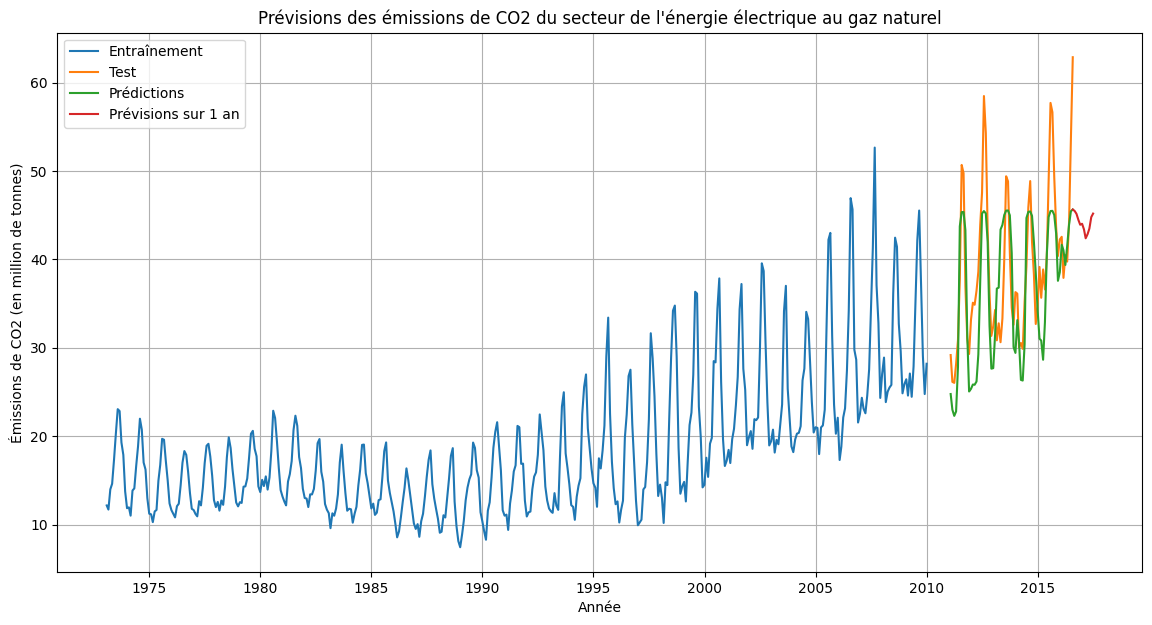

In [27]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(train.index, scaler.inverse_transform(train_scaled.reshape(-1, 1)), label='Entraînement')
plt.plot(test.index[SEQUENCE_SIZE:], actuals, label='Test')
plt.plot(test.index[SEQUENCE_SIZE:], predictions_inv, label='Prédictions')
plt.plot(future_dates, forecast_values, label='Prévisions sur 1 an')
plt.title("Prévisions des émissions de CO2 du secteur de l'énergie électrique au gaz naturel")
plt.xlabel('Année')
plt.ylabel('Émissions de CO2 (en million de tonnes)')
plt.legend()
plt.grid()
plt.show()

## ARIMA & Seasonal ARIMA

### Stationary Test

Nous allons tester si vos données sont stationnaires

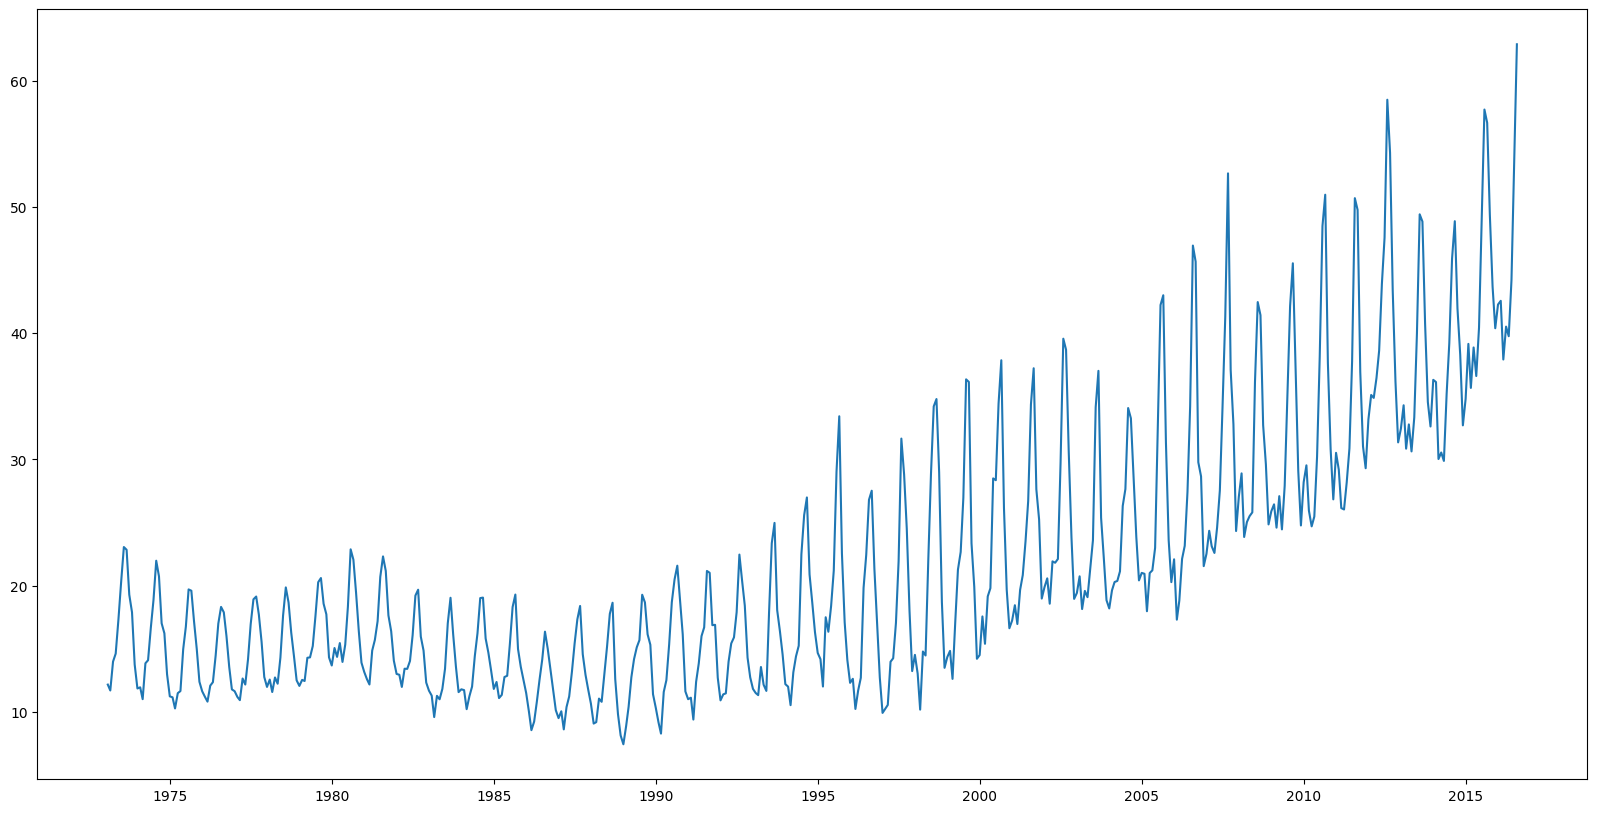

In [35]:
plt.figure(figsize=(20, 10))
plt.plot(mte)

Les chiffres montrent clairement une tendance saisonnière dans les données sur les émissions de CO2. On peut donc conclure que ces données ne sont pas stationnaires.

Mais pour plus de formalité, nous utiliserons Dicky-Fuller

In [36]:
def TestStationaryPlot(ts):
    """
    Visualise la stationnarité d'une série temporelle en traçant :
    - Les données originales
    - La moyenne mobile (rolling mean)
    - L'écart-type mobile (rolling std)
    
    Args:
        ts: Series pandas contenant la série temporelle à analyser
    """
    # Calcul des statistiques mobiles
    rol_mean = ts.rolling(window = 12, center = False).mean() # Moyenne mobile sur 12 périodes
    rol_std = ts.rolling(window = 12, center = False).std() # Écart-type mobile sur 12 périodes
    
    # Configuration du graphique
    plt.figure(figsize=(20, 10))
    plt.plot(ts, color = 'blue',label = 'Données originales')
    plt.plot(rol_mean, color = 'red', label = 'Moyenne mobile')
    plt.plot(rol_std, color ='black', label = "L'écart-type mobile")
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25)
    
    plt.xlabel('Temps en années', fontsize = 25)
    plt.ylabel('Émissions totales', fontsize = 25)
    plt.legend(loc='best', fontsize = 25)
    plt.title('Moyenne mobile et écart type', fontsize = 25)
    plt.show(block= True)

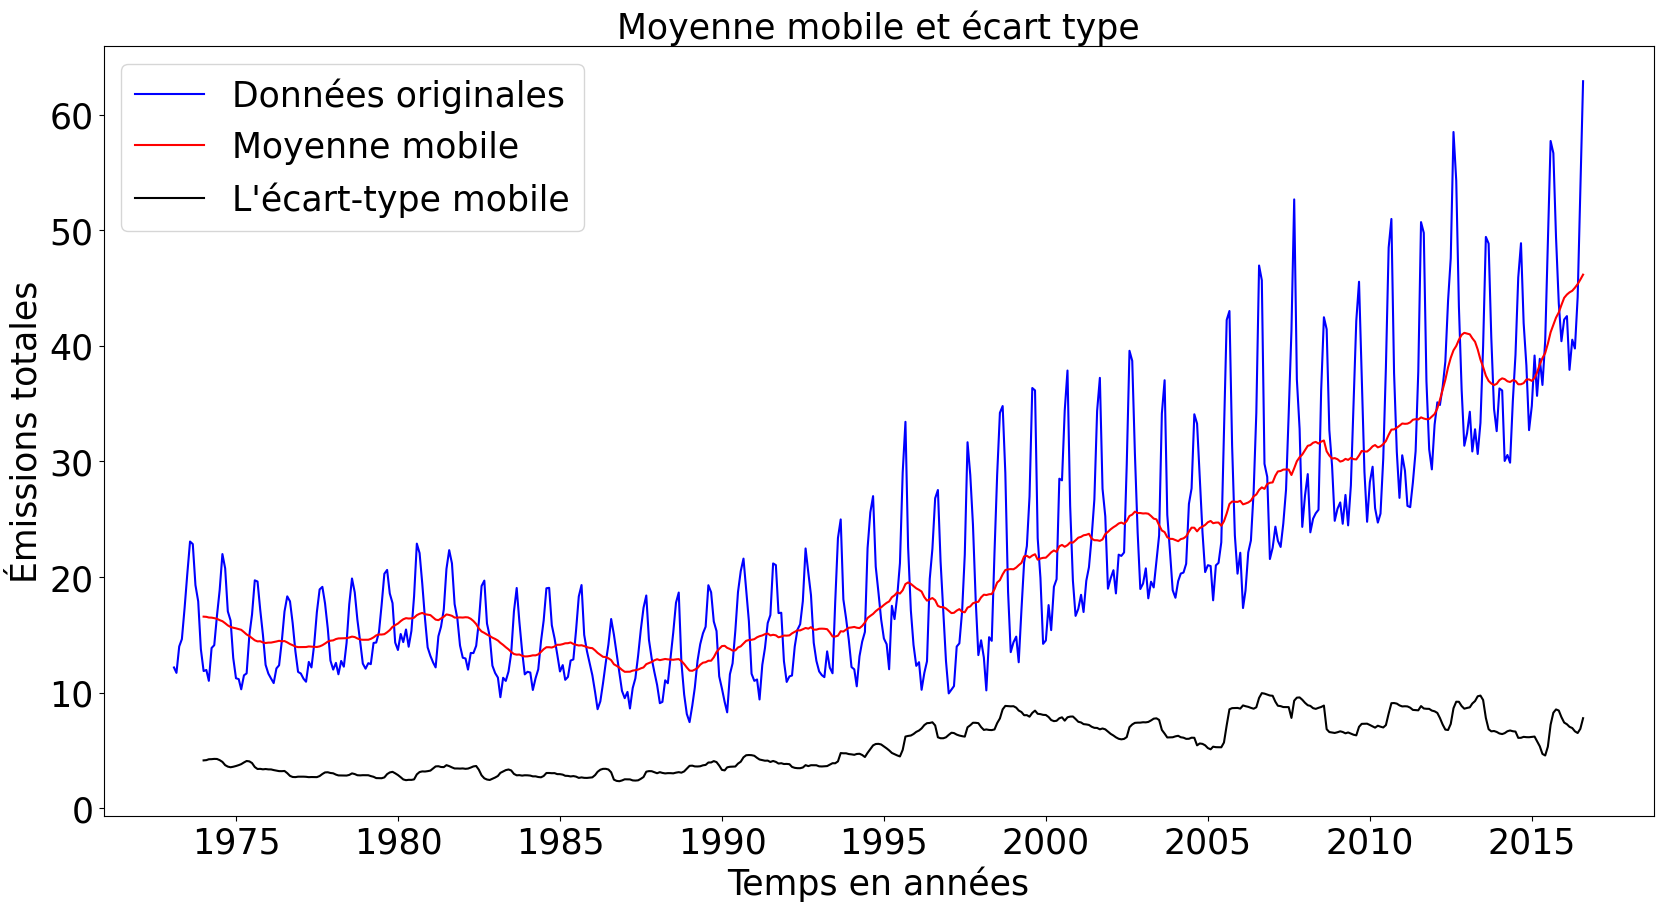

In [37]:
TestStationaryPlot(mte)

In [38]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    """
    Effectue le test de Dickey-Fuller augmenté (ADF) pour évaluer la stationnarité d'une série temporelle
    et interprète les résultats de manière claire.
    
    Args:
        ts: Series pandas contenant la série temporelle à tester
        cutoff: Seuil de signification pour le p-value (défaut: 1%)
    """
    # Exécution du test ADF
    ts_test = adfuller(ts, autolag = 'AIC')
    """
    Retourne un tuple contenant :
    0: Statistique de test
    1: p-value
    2: Nombre de lags utilisés
    3: Nombre d'observations
    4: Dictionnaire des valeurs critiques
    """
    ts_test_output = pd.Series(ts_test[0:4], index=['Statistique de test','valeur p','nombre de décalages utilisés',"Nombre d'observations utilisées"])
    
    # Ajout des valeurs critiques au résultat
    for key,value in ts_test[4].items():
        ts_test_output['Valeur critique (%s)'%key] = value
        
    # Affichage des résultats
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Preuves solides contredisant l'hypothèse nulle, rejeter cette dernière. Les données n'ont pas de racine unitaire, elles sont donc stationnaires.")
    else:
        print("Faible preuve contre l'hypothèse nulle, la série chronologique a une racine unitaire, indiquant qu'elle n'est pas stationnaire")

- Test d'hypothèse où :
    - H0 (nulle) : La série a une racine unitaire (non-stationnaire)
    - H1 : La série n'a pas de racine unitaire (stationnaire)
    
- Si p-value ≤ seuil (1% par défaut):
    - On rejette l'hypothèse nulle (présence de racine unitaire)
    - La série est stationnaire

- Si p-value > seuil:
    - On ne peut pas rejeter l'hypothèse nulle
    - La série est probablement non-stationnaire

In [39]:
TestStationaryAdfuller(mte)

Statistique de test                  1.831215
valeur p                             0.998409
nombre de décalages utilisés        19.000000
Nombre d'observations utilisées    503.000000
Valeur critique (1%)                -3.443418
Valeur critique (5%)                -2.867303
Valeur critique (10%)               -2.569840
dtype: float64
Faible preuve contre l'hypothèse nulle, la série chronologique a une racine unitaire, indiquant qu'elle n'est pas stationnaire


La moyenne des émissions et la variation de l'écart type (ligne noire) varient clairement dans le temps. Cela montre que la série présente une tendance. Elle n'est donc pas stationnaire. De plus, la statistique de test est supérieure aux valeurs critiques avec des niveaux de confiance de 90 %, 95 % et 99 %. Il n'existe donc aucune preuve permettant de rejeter l'hypothèse nulle. La série est donc non stationnaire.

Puisque nos données ne sont pas stationnaires, nous devons les transformer maintenant

Les techniques les plus courantes pour estimer ou modéliser une tendance, puis la supprimer de la série chronologique, sont :
- Agrégation : calcul de la moyenne sur une période donnée, par exemple mensuelle ou hebdomadaire
- Lissage : calcul de moyennes mobiles
- Ajustement polynomial : ajustement d'un modèle de régression

L'une des méthodes les plus courantes pour traiter à la fois la tendance et la saisonnalité est la différenciation. Cette technique consiste à prendre en compte la différence entre l'observation initiale à un instant donné et celle à l'instant précédent. Cette méthode est généralement efficace pour améliorer la stationnarité. La différenciation de premier ordre peut être réalisée comme suit :

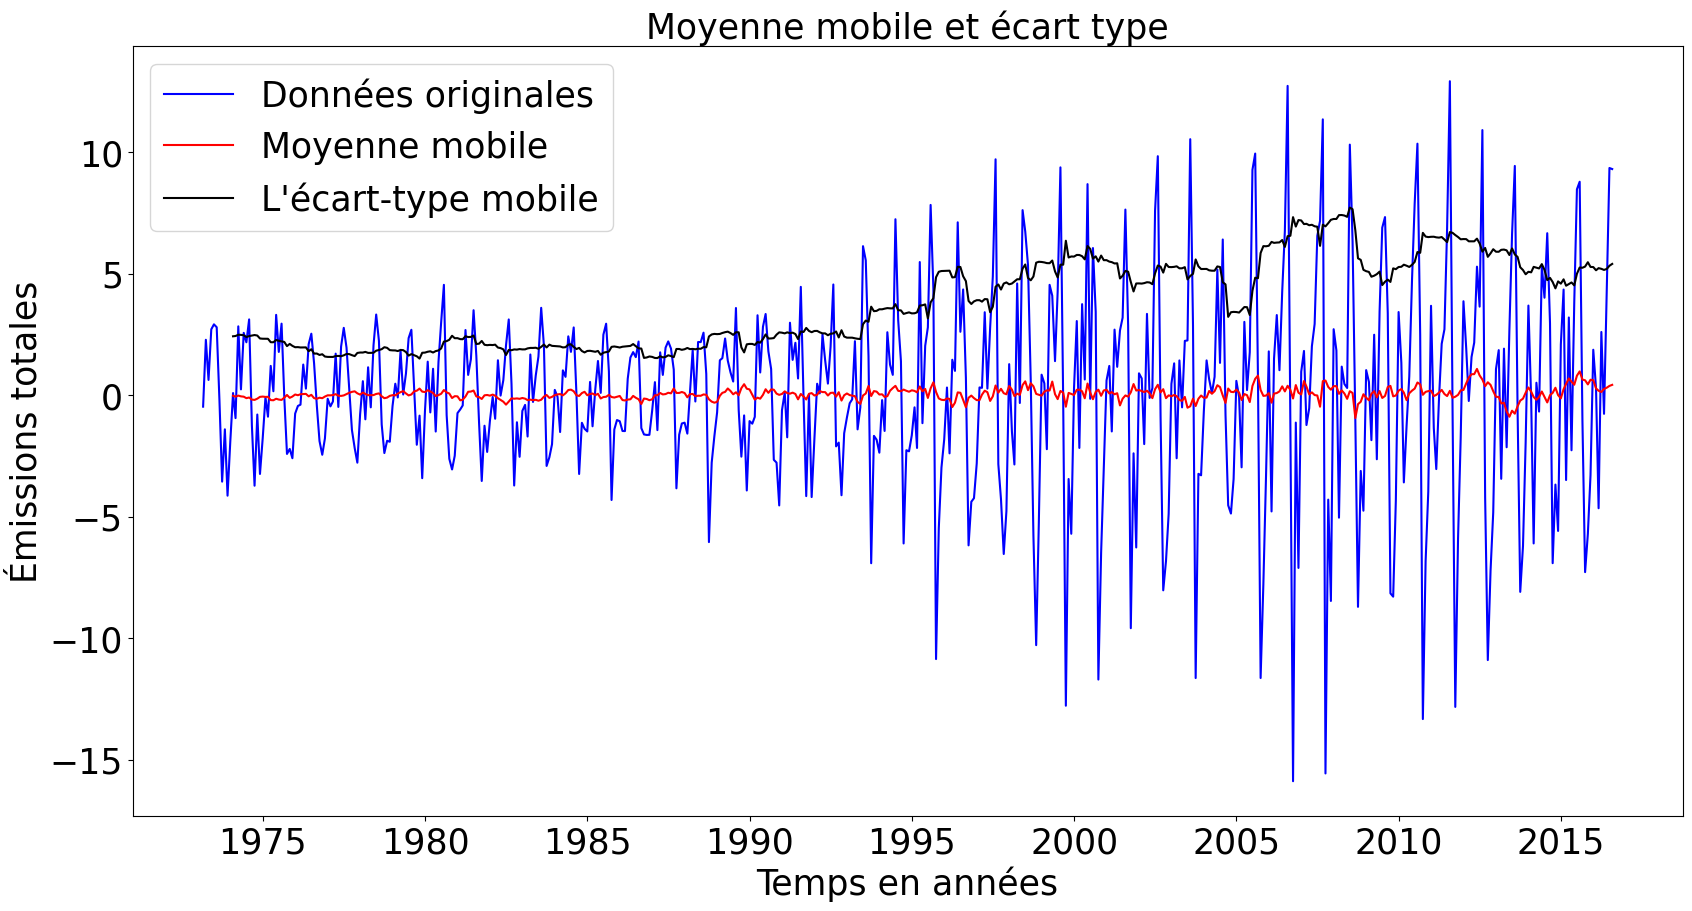

In [40]:
"""
Opération de différenciation :
- mte.shift(1) : Décale la série d'une période vers le bas
- mte - mte.shift(1) : Calcule la différence entre chaque point et son prédécesseur
Effet : 
- Élimine la tendance linéaire
- Réduit la saisonnalité (selon la fréquence des données)
Exemple pour une série [a, b, c] :
shift(1) → [NaN, a, b]
diff → [NaN, b-a, c-b]
"""
mte_first_difference = mte - mte.shift(1)  
TestStationaryPlot(mte_first_difference.dropna(inplace=False))

In [41]:
TestStationaryAdfuller(mte_first_difference.dropna(inplace=False))

Statistique de test                 -5.435116
valeur p                             0.000003
nombre de décalages utilisés        18.000000
Nombre d'observations utilisées    503.000000
Valeur critique (1%)                -3.443418
Valeur critique (5%)                -2.867303
Valeur critique (10%)               -2.569840
dtype: float64
Preuves solides contredisant l'hypothèse nulle, rejeter cette dernière. Les données n'ont pas de racine unitaire, elles sont donc stationnaires.


La première différence améliore considérablement la stationnarité de la série. Utilisons également la ***différence saisonnière*** pour supprimer la saisonnalité des données et observer son impact sur la stationnarité des données.

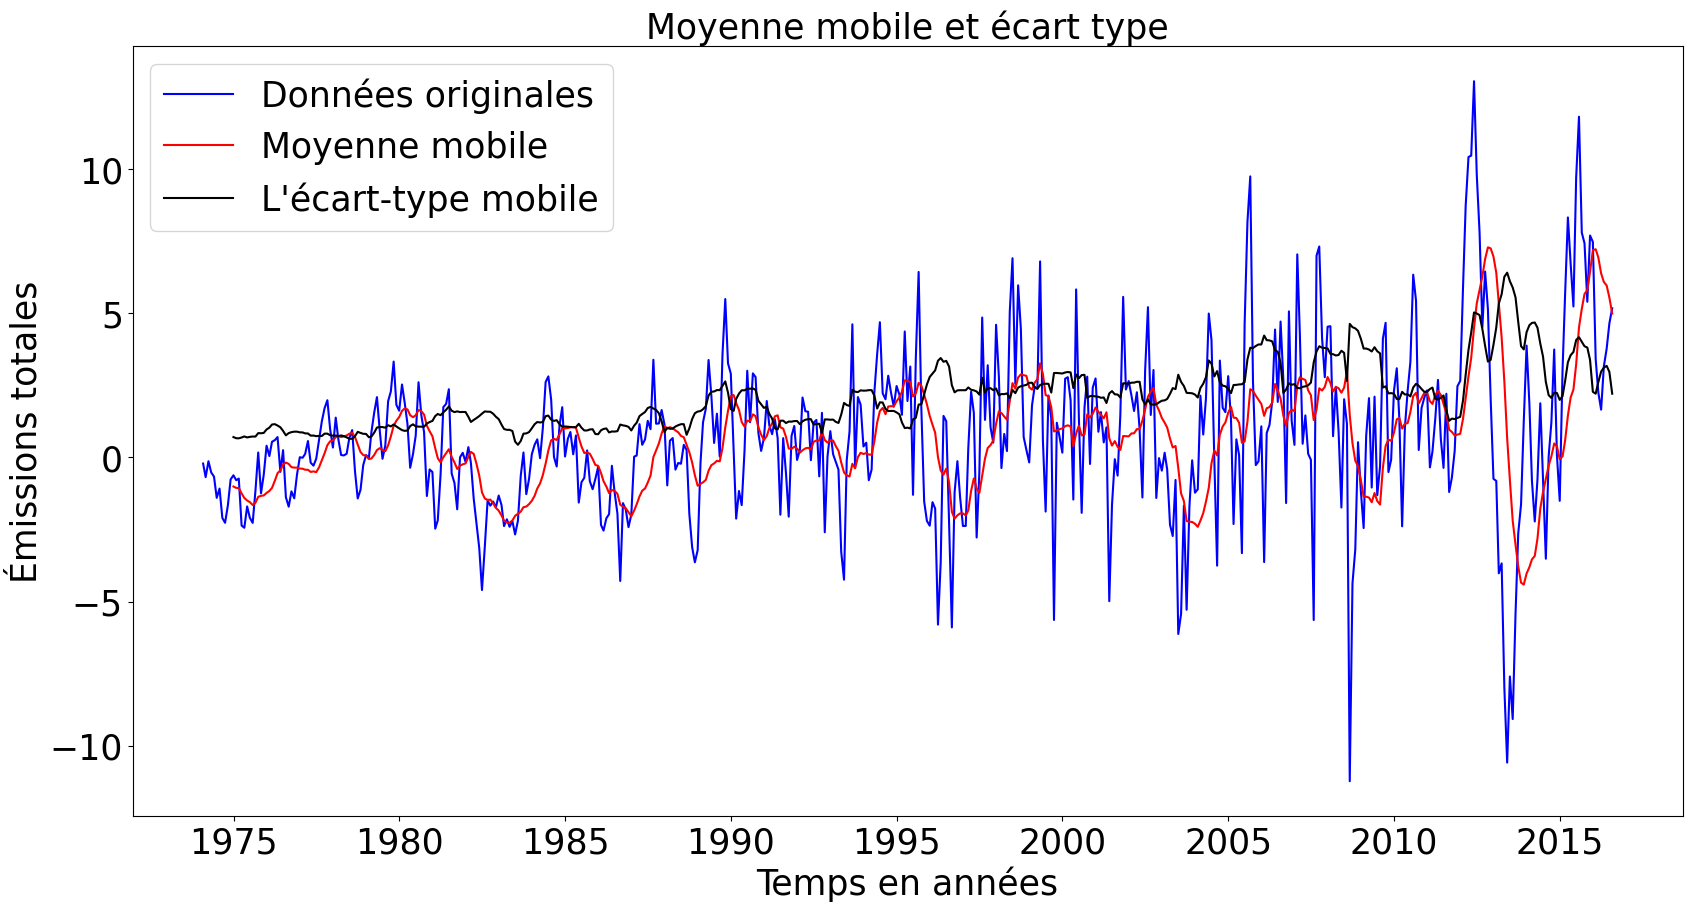

Statistique de test                 -4.412396
valeur p                             0.000282
nombre de décalages utilisés        13.000000
Nombre d'observations utilisées    497.000000
Valeur critique (1%)                -3.443576
Valeur critique (5%)                -2.867373
Valeur critique (10%)               -2.569877
dtype: float64
Preuves solides contredisant l'hypothèse nulle, rejeter cette dernière. Les données n'ont pas de racine unitaire, elles sont donc stationnaires.


In [42]:
mte_seasonal_difference = mte - mte.shift(12)  
TestStationaryPlot(mte_seasonal_difference.dropna(inplace=False))
TestStationaryAdfuller(mte_seasonal_difference.dropna(inplace=False))

Par rapport aux données d'origine, la différence saisonnière améliore également la stationnarité de la série. L'étape suivante consiste à prendre la première différence de la différence saisonnière.

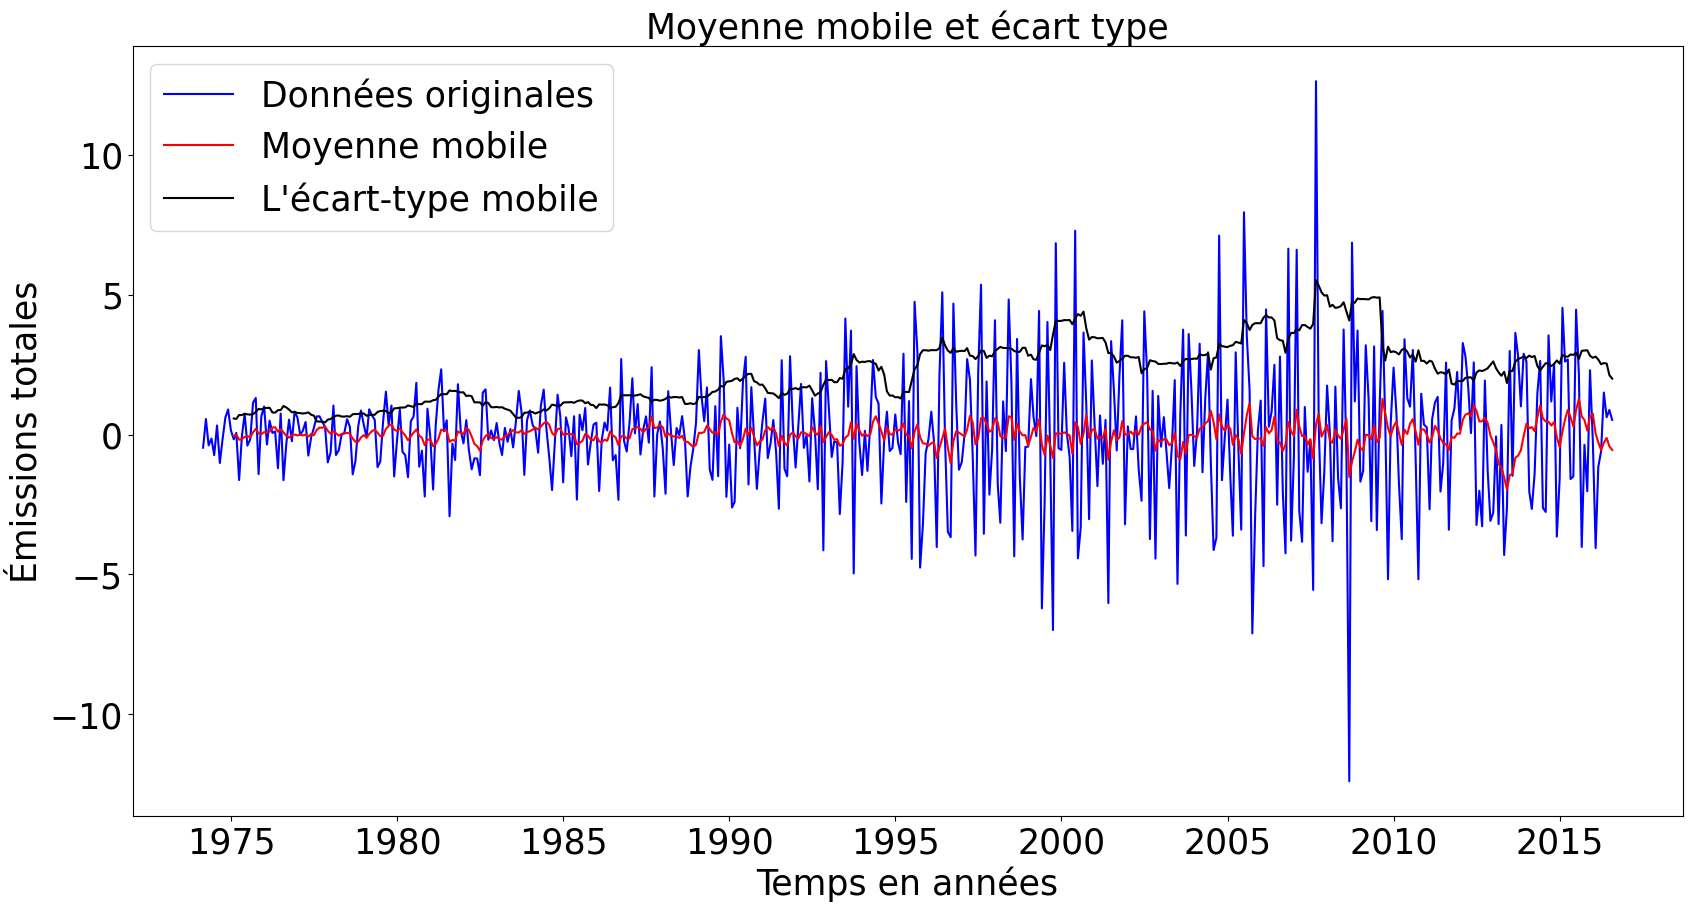

In [43]:
mte_seasonal_first_difference = mte_first_difference - mte_first_difference.shift(12)  
TestStationaryPlot(mte_seasonal_first_difference.dropna(inplace=False))

In [44]:
TestStationaryAdfuller(mte_seasonal_first_difference.dropna(inplace=False))

Statistique de test               -1.009743e+01
valeur p                           1.081539e-17
nombre de décalages utilisés       1.200000e+01
Nombre d'observations utilisées    4.970000e+02
Valeur critique (1%)              -3.443576e+00
Valeur critique (5%)              -2.867373e+00
Valeur critique (10%)             -2.569877e+00
dtype: float64
Preuves solides contredisant l'hypothèse nulle, rejeter cette dernière. Les données n'ont pas de racine unitaire, elles sont donc stationnaires.


Si l'on examine maintenant la statistique de test et la valeur p, la prise en compte de la première différence saisonnière a rendu notre série chronologique stationnaire. Cette procédure de différenciation aurait pu être répétée pour les valeurs logarithmiques, mais elle n'aurait pas rendu l'ensemble de données plus stationnaire.

### Parameters

Maintenant que nos données sont stationnaires, nous allons trouver le paramètre optimal pour nos modèles ARIMA et SARIMA :

Pour ajuster un ensemble de données chronologiques à un modèle ARIMA/saisonnier, notre premier objectif est de trouver les valeurs de ARIMA(p,d,q)/SARIMA(p,d,q)(P,D,Q) qui optimisent notre métrique d'intérêt.

Moyenne mobile intégrée autorégressive (ARIMA) : La prévision ARIMA pour une série chronologique stationnaire est une fonction linéaire similaire à la régression linéaire. Les prédicteurs dépendent principalement des paramètres (p,d,q) du modèle ARIMA :

* Nombre de termes autorégressifs (AR) (p) : Les termes AR ne sont que des décalages de la variable dépendante. Par exemple, si p est égal à 4, les prédicteurs de x(t) dépendront de x(t-1)….x(t-4). Ce terme nous permet d'intégrer l'effet des valeurs passées dans notre modèle. Cela reviendrait à affirmer qu'il fera probablement chaud demain s'il a fait chaud les 4 derniers jours.
* Nombre de termes de moyenne mobile (MM) (q)** : Les termes de MM sont des erreurs de prévision décalées dans la fonction de prédiction. Ce terme nous permet de définir l'erreur de notre modèle comme une combinaison linéaire des valeurs d'erreur observées à des instants précédents. Par exemple, si q est égal à 4, les prédicteurs de x(t) seront e(t-1)….e(t-4), où e(i) est la différence entre la moyenne mobile au ième instant et la valeur réelle.
* Nombre de différences (d)** : Il s'agit du nombre de différences non saisonnières, c'est-à-dire si l'on considère la différence de premier ordre. Nous pouvons donc soit passer la variable de différence de premier ordre et définir d=0, soit passer la variable observée d'origine et définir d=1. Les deux produiront les mêmes résultats. Ce terme explique le nombre de points passés à soustraire de la valeur actuelle. Cela reviendrait à dire qu'il est probable que la température sera la même demain si la différence de température des trois derniers jours a été très faible.

#### Tracez les graphiques ACF et PACF et trouvez les paramètres optimaux

* **Fonction d'autocorrélation (ACF)** : Il s'agit d'une mesure de la corrélation entre la série temporelle (ts) et une version retardée d'elle-même. Par exemple, à un décalage de 4, l'ACF compare la série aux instants « t1 »… « t2 » avec la série aux instants « t1-4 »… « t2-4 » (t1-4 et t2 étant les extrémités de la plage).
* **Fonction d'autocorrélation partielle (PACF)** : Elle mesure la corrélation entre la série temporelle (ts) et une version retardée d'elle-même, après avoir éliminé les variations déjà expliquées par les comparaisons intermédiaires. Par exemple, à un décalage de 4, elle vérifie la corrélation, mais supprime les effets déjà expliqués par les décalages de 1 à 3.

L'étape suivante consiste donc à déterminer les paramètres de réglage (p et q) du modèle en examinant les graphiques d'autocorrélation et d'autocorrélation partielle. Le tableau ci-dessous fournit un bref guide sur la façon de lire les graphiques d'autocorrélation et d'autocorrélation partielle afin de sélectionner les paramètres.

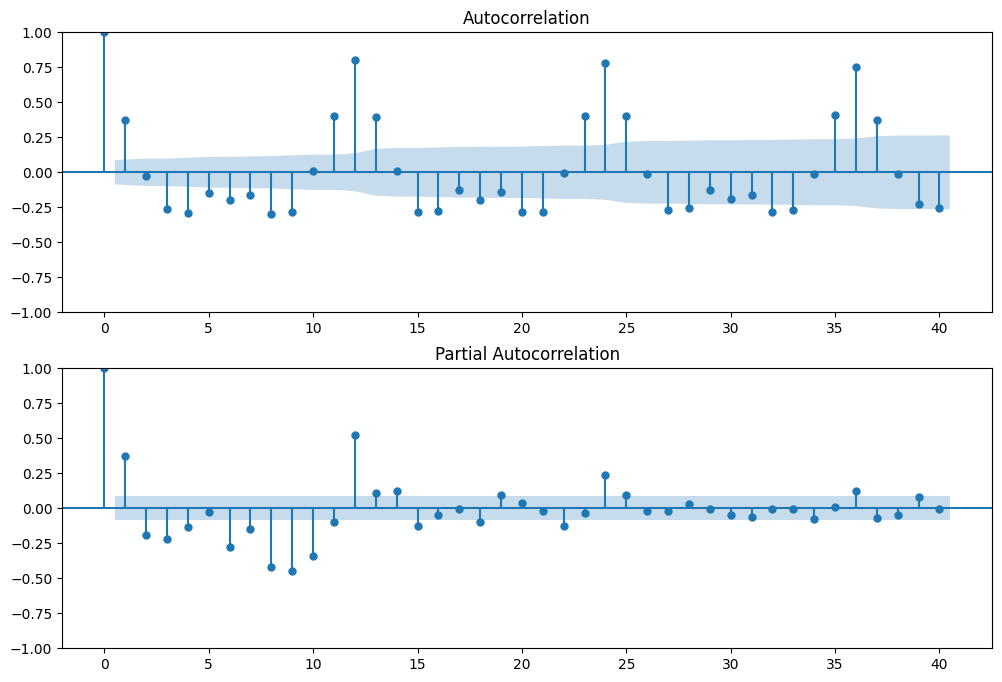

In [45]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mte_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mte_first_difference.iloc[13:], lags=40, ax=ax2)

- PACF a un pic à lag 1 → AR(1)
- ACF a un pic à lag 1 → MA(1)

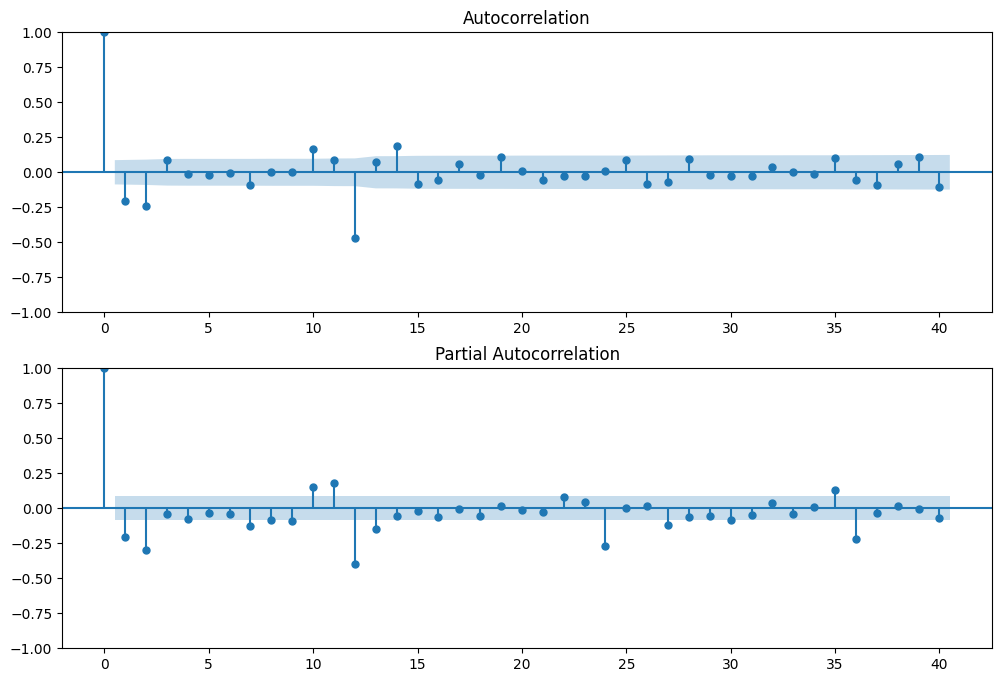

In [46]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mte_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

### ARIMA

In [47]:
# Test de Dickey-Fuller augmenté
adf_result = adfuller(mte.dropna())
print(f"ADF p-value: {adf_result[1]}")

# Si la valeur p > 0,05, différencier les données
if adf_result[1] > 0.05:
    mte = mte.diff().dropna()

ADF p-value: 0.9984089578807273


In [48]:
# Division des données de train et test
train_size = int(0.7 * len(mte))
test_size = len(mte) - train_size

train = mte.iloc[:train_size]
test = mte.iloc[train_size:]

In [49]:
# Trouver la dernière date du dataset complet
last_date = pd.concat([train, test]).index[-1]

# Créer un index de dates pour l'année suivante (12 mois)
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                            periods=12, 
                            freq='M')

In [50]:
# Trouver les meilleurs paramétre avec auto-arima
model = auto_arima(mte,           
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2640.954, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2938.466, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2860.302, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2854.068, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2936.770, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2782.231, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2712.505, Time=0.35 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2635.777, Time=0.49 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2703.820, Time=0.24 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=2702.537, Time=0.34 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=2630.372, Time=0.48 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2630.338, Time=0.44 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2747.592, Time=0.31 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : 

In [51]:
# Stockage des résultats de validation croisée
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []

# Validation croisée pour le modèle ARIMA
for train_index, val_index in tscv.split(train):
    # Séparation des données
    train_cv, val_cv = train.iloc[train_index], train.iloc[val_index]

    # Entraînement ARIMA
    model_arima = ARIMA(train_cv, order=(2, 0, 3))
    model_arima_fit = model_arima.fit()
    # Prédiction
    predictions_arima = model_arima_fit.forecast(steps=len(val_cv))
    
    # Calcul des métriques
    mse = mean_squared_error(val_cv, predictions_arima)
    rmse = np.sqrt(mean_squared_error(val_cv, predictions_arima))
    mae = mean_absolute_error(val_cv, predictions_arima)
    r2 = r2_score(val_cv, predictions_arima)
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Affichage des résultats de validation croisée
print(f'MSE moyen ARIMA: {np.mean(mse_scores)}')
print(f'RMSE moyen ARIMA: {np.mean(rmse_scores)}')
print(f'MAE moyen ARIMA: {np.mean(mae_scores)}')
print(f'R² moyen ARIMA: {np.mean(r2_scores)}')
    

/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: C

MSE moyen ARIMA: 7.335507975501386
RMSE moyen ARIMA: 2.4651123631049705
MAE moyen ARIMA: 1.9795066660208043
R² moyen ARIMA: 0.28199301910237307


**TimeSeriesSplit :**
- Conserve l'ordre temporel (crucial pour les séries temporelles)
- Évite le "data leakage" en empêchant le modèle de voir le futur
- Génère des splits progressifs (ex: [1,2,3] → [4], puis [1,2,3,4] → [5], etc.)

**Ordre ARIMA(2,0,3) :**
- AR(2) : 2 termes autorégressifs
- I(0) : Pas de différenciation 
- MA(3) : 3 termes de moyenne mobile

In [52]:
# Évaluation du modèle ARIMA sur l'ensemble de test
model_arima_final = ARIMA(train, order=(2, 0, 3))
start_train = time.time()
model_arima_final_fit = model_arima_final.fit()
end_train = time.time()
training_time_arima = end_train - start_train

start_inference = time.time()
predictions_arima_final = model_arima_final_fit.forecast(steps=len(test))
end_inference = time.time()
inference_time_arima = end_inference - start_inference

# Évaluation des performances
mse_test_arima = mean_squared_error(test, predictions_arima_final)
rmse_test_arima = np.sqrt(mean_squared_error(test, predictions_arima_final))
mae_test_arima = mean_absolute_error(test, predictions_arima_final)
r2_test_arima = r2_score(test, predictions_arima_final)
arima_par = 5 #(2+0+3)

# Prévision pour une année supplémentaire
year_forecast_arima = model_arima_final_fit.forecast(steps=12)

print(f'ARIMA - MSE Test: {mse_test_arima}, RMSE Test: {rmse_test_arima}, MAE Test: {mae_test_arima}, R² Test: {r2_test_arima}, Training Time: {training_time_arima}, Inference Time: {inference_time_arima}, Parameters: {arima_par}')

ARIMA - MSE Test: 27.63479716831311, RMSE Test: 5.256880935337333, MAE Test: 4.09469957632194, R² Test: 0.11831975607582534, Training Time: 0.3123505115509033, Inference Time: 0.009389638900756836, Parameters: 5


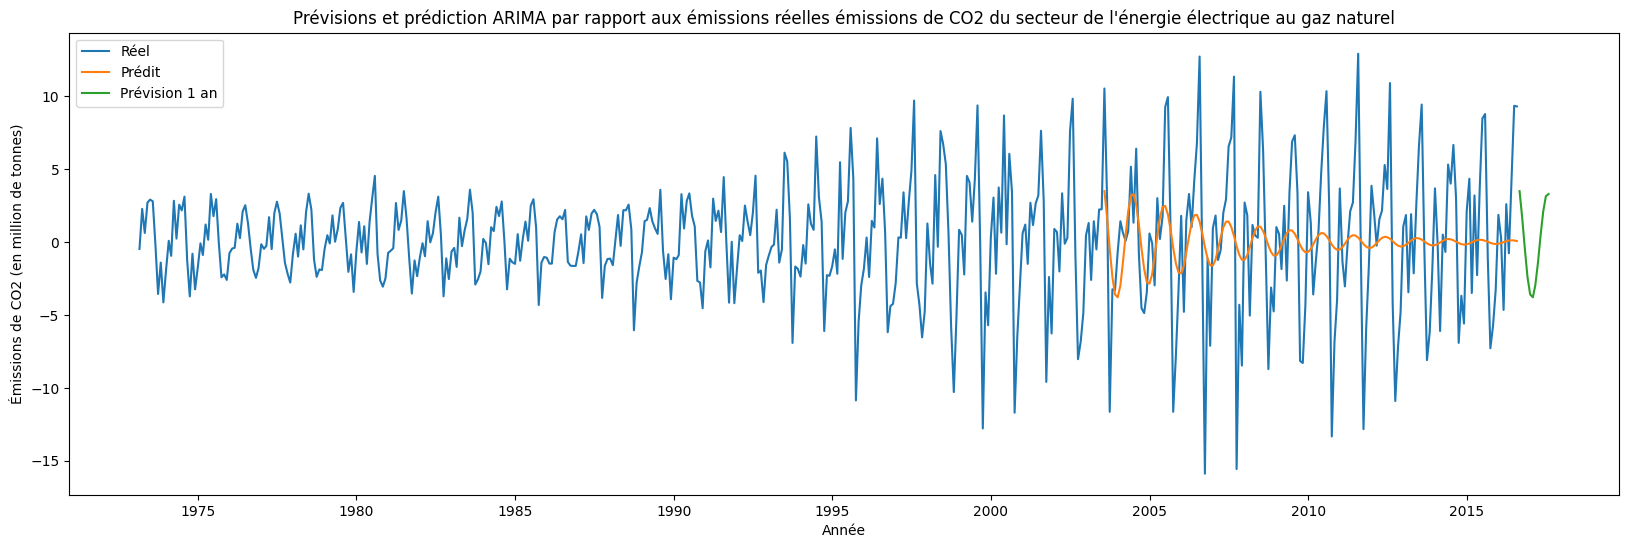

In [53]:
# Plot predictions vs actuals
plt.figure(figsize=(20, 6))
plt.plot(mte.index, mte, label="Réel")
plt.plot(test.index, predictions_arima_final, label="Prédit")
plt.plot(future_dates, year_forecast_arima, label='Prévision 1 an')
plt.legend()
plt.title("Prévisions et prédiction ARIMA par rapport aux émissions réelles émissions de CO2 du secteur de l'énergie électrique au gaz naturel")
plt.xlabel("Année")
plt.ylabel("Émissions de CO2 (en million de tonnes)")
plt.show()

### SARIMA

Trouver les paramètres optimaux pour les modèles SARIMA à l'aide de la recherche par grille (optimisation des hyperparamètres). Cette recherche explore de manière itérative différentes combinaisons de paramètres. Notre ensemble optimal sera celui qui offre les meilleures performances pour nos critères d'intérêt. Commençons par générer les différentes combinaisons de paramètres que nous souhaitons évaluer :

In [54]:
p = d = q = range(0, 2) # Définissez les paramètres p, d et q pour prendre n'importe quelle valeur entre 0 et 2
pdq = list(itertools.product(p, d, q)) # Générer toutes les différentes combinaisons de triplets p, q et q
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Générer toutes les différentes combinaisons de triplets saisonniers p, q et q

In [55]:
# Initialisation des variables pour stocker les meilleurs résultats
best_aic = float("inf")  # Initialise avec l'infini positif (valeur à battre)
best_order = None         # Stockera le meilleur ordre non saisonnier (p,d,q)
best_seasonal_order = None  # Stockera le meilleur ordre saisonnier (P,D,Q,s)
best_model = None         # Stockera le modèle optimal trouvé

# Double boucle pour tester toutes les combinaisons
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            # Création du modèle SARIMAX avec les paramètres courants
            mod = sm.tsa.statespace.SARIMAX(
                mte,
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            # Estimation du modèle
            results = mod.fit(disp=False)
            aic = results.aic

            print(f"ARIMA{param}x{seasonal_param} - AIC:{aic:.2f}")

             # Mise à jour si meilleur modèle trouvé
            if aic < best_aic:
                best_aic = aic
                best_order = param
                best_seasonal_order = seasonal_param
                best_model = results

        except Exception as e:
            # Gestion des erreurs (paramètres non valides)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:2932.13
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:2616.31
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:2329.05


ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2068.57
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:2295.75


/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:2109.46
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:2162.69
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:2074.05
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:2842.81
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2581.89
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:2281.27
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:2040.64
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:2268.80
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2081.11
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:2123.30
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:2044.99
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:3038.05
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:2825.26
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:2773.38
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:2486.15
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:2691.67
ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:2538.43
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:2605.34
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:2488.15
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:2930.05
ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:2613.99
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:2328.95


/home/manel/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:2069.81
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:2300.43
ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:2113.00
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:2167.51
ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:2071.81
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:2853.83
ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:2593.33
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:2308.60
ARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC:2053.72
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:2280.91
ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:2093.66
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:2134.90
ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:2058.36
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:2841.55
ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:2583.17
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:2240.24
ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:2003.86
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:2219.73
ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:2044.79
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:2096.45
ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:2005.76
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:3022.53
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:2787.64
ARIMA(1, 1,

Lors de l'ajustement des modèles ARIMA saisonniers, il est important d'effectuer des diagnostics afin de s'assurer qu'aucune de ses hypothèses n'a été violée. Tout d'abord, nous obtenons un tracé linéaire des erreurs résiduelles, suggérant que certaines informations de tendance pourraient encore ne pas être capturées par le modèle.

<Axes: xlabel='YYYYMM'>

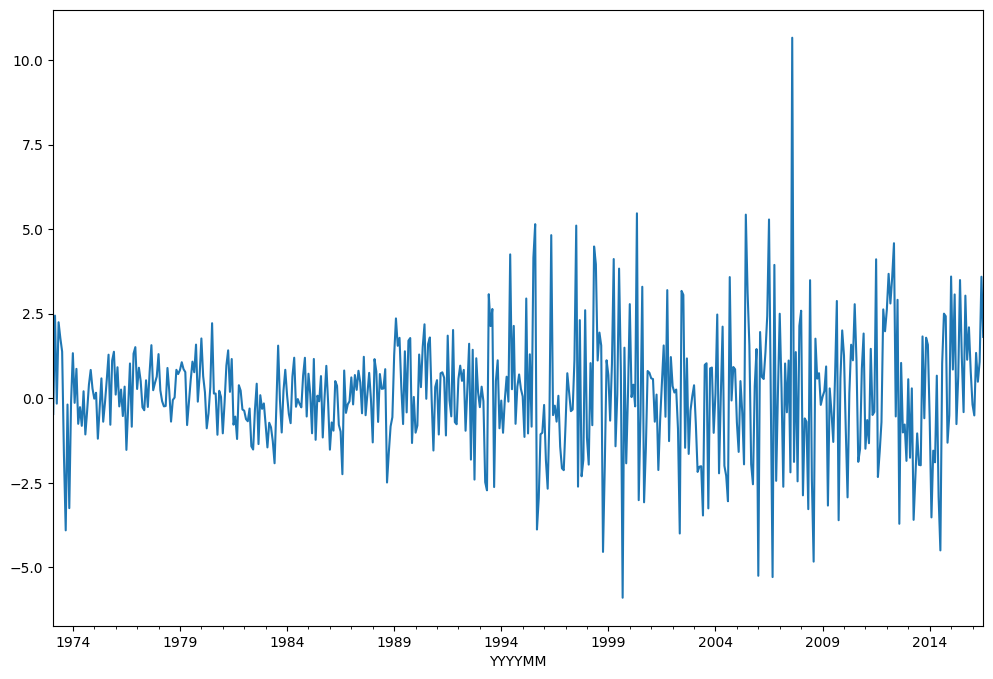

In [56]:
fig = plt.figure(figsize=(12,8))
best_model.resid.plot()

In [57]:
print(best_model.resid.describe())

count    522.000000
mean       0.135830
std        1.780828
min       -5.899880
25%       -0.787397
50%        0.130589
75%        1.036159
max       10.659547
dtype: float64


La figure présente la distribution des erreurs résiduelles. Elle révèle un léger biais dans la prédiction. Ensuite, nous obtenons un graphique de densité des valeurs d'erreur résiduelle, suggérant que les erreurs sont gaussiennes, mais pourraient ne pas être centrées sur zéro.

<Axes: ylabel='Density'>

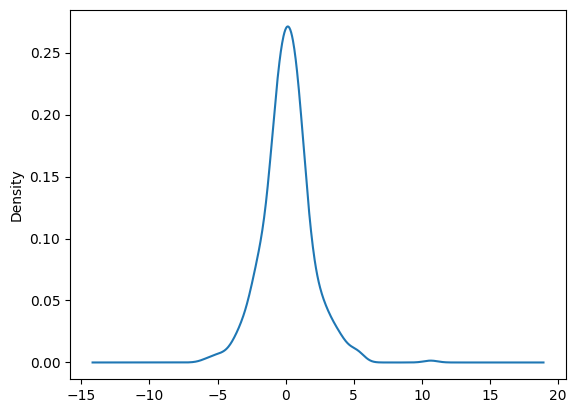

In [58]:
best_model.resid.plot(kind='kde')

L'objet plot_diagnostics nous permet de générer rapidement des diagnostics de modèle et d'enquêter sur tout comportement inhabituel.

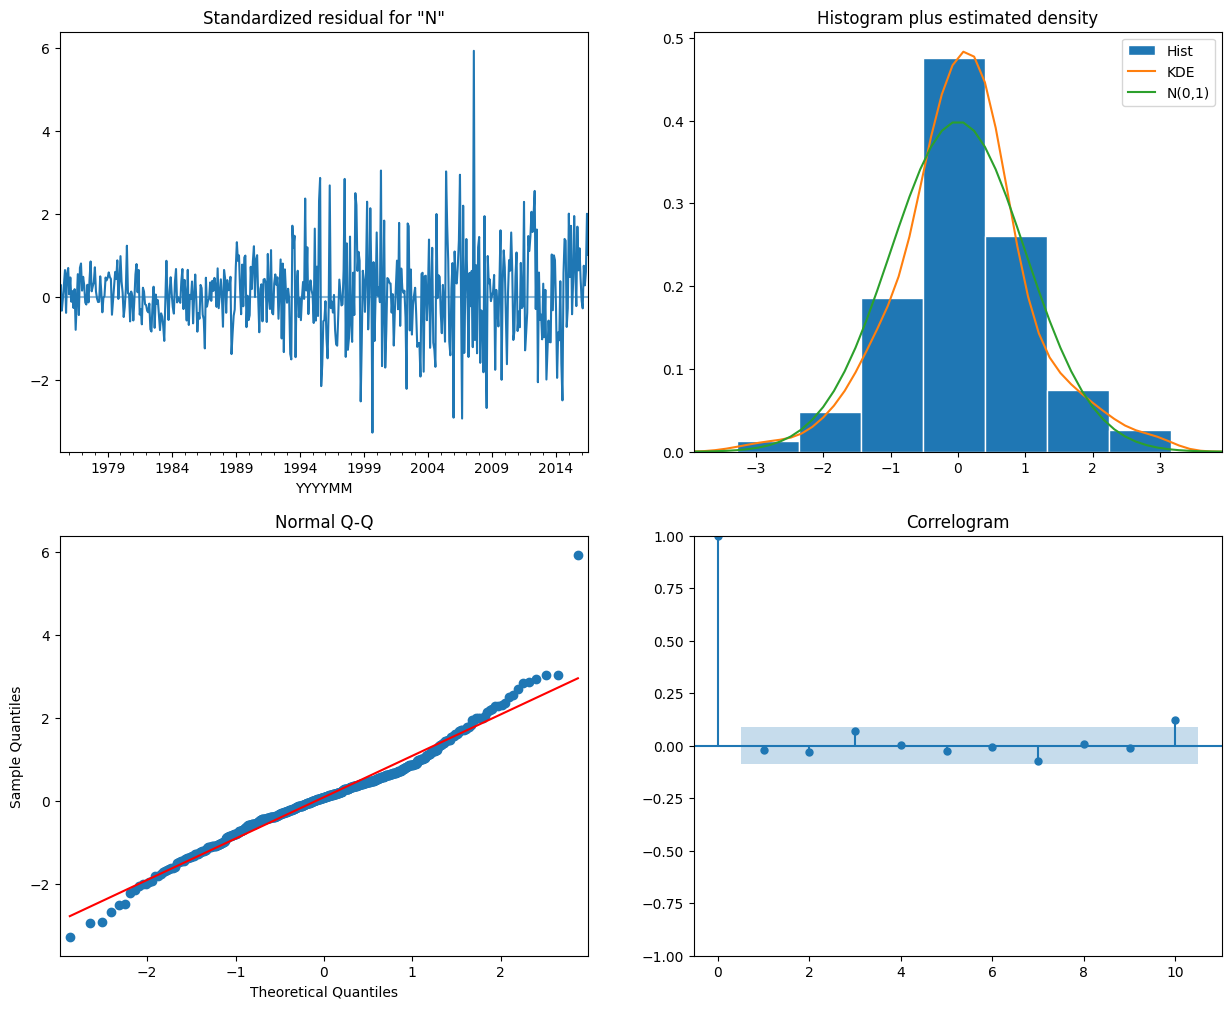

In [59]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Notre principale préoccupation est de garantir que les résidus de notre modèle sont décorrélés et normalement distribués avec une moyenne nulle. Si le modèle ARIMA saisonnier ne satisfait pas à ces propriétés, cela indique qu'il peut être encore amélioré.

Le diagnostic du modèle suggère que le résidu du modèle est normalement distribué, comme suit :

- Dans le graphique en haut à droite, la droite KDE rouge suit de près la droite N(0,1). N(0,1) étant la notation standard d'une distribution normale avec une moyenne de 0 et un écart type de 1. Ceci indique que les résidus sont normalement distribués. Les erreurs de prévision s'écartent légèrement de la droite, ce qui indique que la distribution normale n'est pas un modèle parfait pour la distribution des erreurs de prévision, mais ce n'est pas déraisonnable.
- Le graphique qq en bas à gauche montre que la distribution ordonnée des résidus (points bleus) suit la tendance linéaire des échantillons prélevés dans une distribution normale standard. Là encore, cela indique fortement que les résidus sont normalement distribués. 
- Les résidus au fil du temps (graphique en haut à gauche) ne présentent pas de saisonnalité évidente et semblent être du bruit blanc. Ceci est confirmé par le graphique d'autocorrélation (corrélogramme) en bas à droite, qui montre que les résidus de la série temporelle sont faiblement corrélés avec leurs versions décalées.

Ces observations nous amènent à conclure que notre modèle produit un ajustement satisfaisant, ce qui pourrait nous aider à comprendre nos données de séries temporelles et à prévoir les valeurs futures.

In [60]:
best_order 

(1, 0, 1)

In [61]:
best_seasonal_order

(0, 1, 1, 12)

In [62]:
# Stockage des résultats de validation croisée
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []

# Validation croisée pour le modèle ARIMA
for train_index, val_index in tscv.split(train):
    train_cv, val_cv = train.iloc[train_index], train.iloc[val_index]
    model_sarima = SARIMAX(train_cv, order=best_order, seasonal_order=best_seasonal_order)
    model_sarima_fit = model_sarima.fit(disp=False)
    predictions_sarima = model_sarima_fit.forecast(steps=len(val_cv))
    
    mse = mean_squared_error(val_cv, predictions_sarima)
    rmse = np.sqrt(mean_squared_error(val_cv, predictions_arima))
    mae = mean_absolute_error(val_cv, predictions_sarima)
    r2 = r2_score(val_cv, predictions_sarima)
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Affichage des résultats de validation croisée
print(f'MSE moyen SARIMA: {np.mean(mse_scores)}')
print(f'RMSE moyen ARIMA: {np.mean(rmse_scores)}')
print(f'MAE moyen SARIMA: {np.mean(mae_scores)}')
print(f'R² moyen SARIMA: {np.mean(r2_scores)}')

MSE moyen SARIMA: 2.8315663917482676
RMSE moyen ARIMA: 4.09495245938578
MAE moyen SARIMA: 1.1715081451934508
R² moyen SARIMA: 0.7333097086761529


In [63]:
# Évaluation du modèle ARIMA sur l'ensemble de test
model_sarima_final = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
start_train = time.time()
model_sarima_final_fit = model_sarima_final.fit(disp=False)
end_train = time.time()
training_time_sarima = end_train - start_train

start_inference = time.time()
predictions_sarima_final = model_sarima_final_fit.forecast(steps=len(test))
end_inference = time.time()
inference_time_sarima = end_inference - start_inference

# Évaluation des performances
mse_test_sarima = mean_squared_error(test, predictions_sarima_final)
rmse_test_sarima = np.sqrt(mean_squared_error(test, predictions_sarima_final))
mae_test_sarima = mean_absolute_error(test, predictions_sarima_final)
r2_test_sarima = r2_score(test, predictions_sarima_final)
sarima_par = 4 #(1+0+1+0+1+1)

n_forecast = 12  # or 365 if daily
sarima_forecast = best_model.forecast(steps=n_forecast)

print(f'SARIMA - MSE Test: {mse_test_sarima}, RMSE Test: {rmse_test_sarima}, MAE Test: {mae_test_sarima}, R² Test: {r2_test_sarima}, Training Time: {training_time_sarima}, Inference Time: {inference_time_sarima}, Parameters: {sarima_par}')

SARIMA - MSE Test: 6.387143109581861, RMSE Test: 2.52727978458695, MAE Test: 1.954039990334397, R² Test: 0.7962200387961631, Training Time: 0.33460116386413574, Inference Time: 0.018031835556030273, Parameters: 4


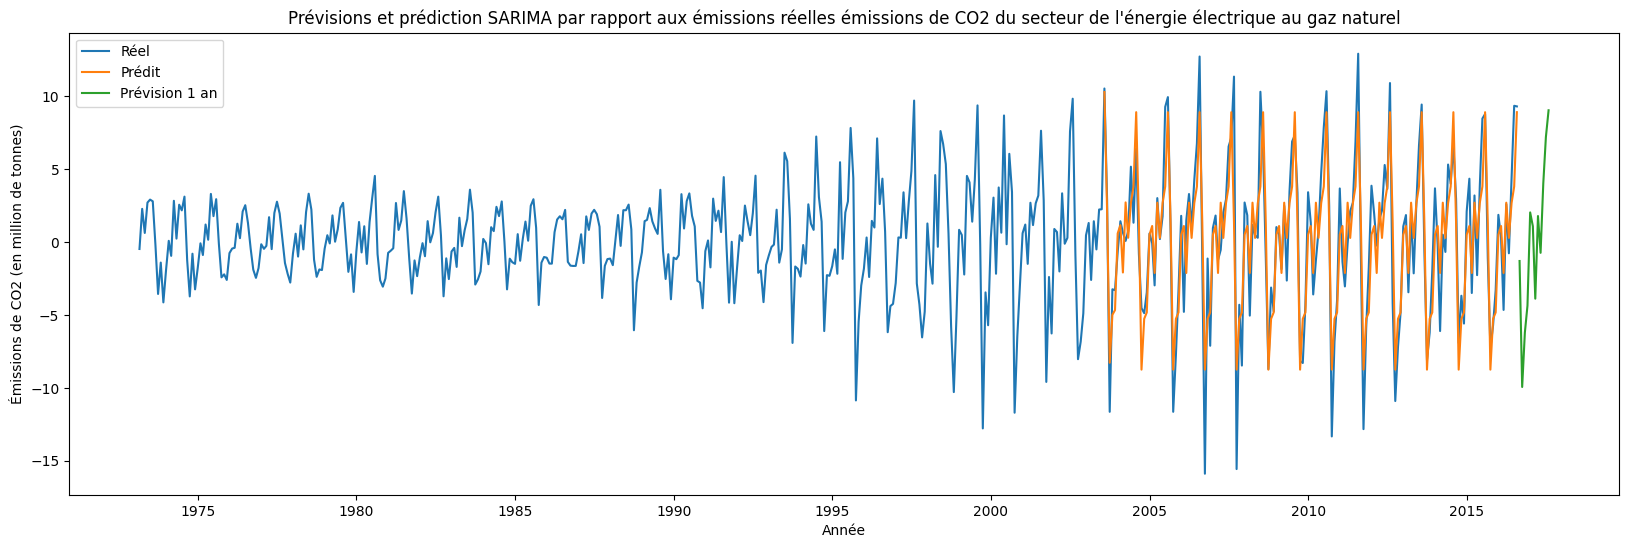

In [64]:
# Plot predictions vs actuals
plt.figure(figsize=(20, 6))
plt.plot(mte.index, mte, label="Réel")
plt.plot(test.index, predictions_sarima_final, label="Prédit")
plt.plot(future_dates, sarima_forecast, label='Prévision 1 an')
plt.legend()
plt.title("Prévisions et prédiction SARIMA par rapport aux émissions réelles émissions de CO2 du secteur de l'énergie électrique au gaz naturel")
plt.xlabel("Année")
plt.ylabel("Émissions de CO2 (en million de tonnes)")
plt.show()

# Comparaison



Comparaison de modèles
                   MSE      RMSE       MAE        R²  Training Time  \
ARIMA        27.634797  5.256881  4.094700  0.118320       0.312351   
SARIMA        6.387143  2.527280  1.954040  0.796220       0.334601   
LSTM         30.686225  5.539515  4.660139  0.600388       9.620488   
Transformer  38.316784  6.190055  5.101216  0.448235       0.018886   

             Inference Time  Parameters  
ARIMA              0.009390           5  
SARIMA             0.018032           4  
LSTM               0.270403       16961  
Transformer        0.007200      847809  


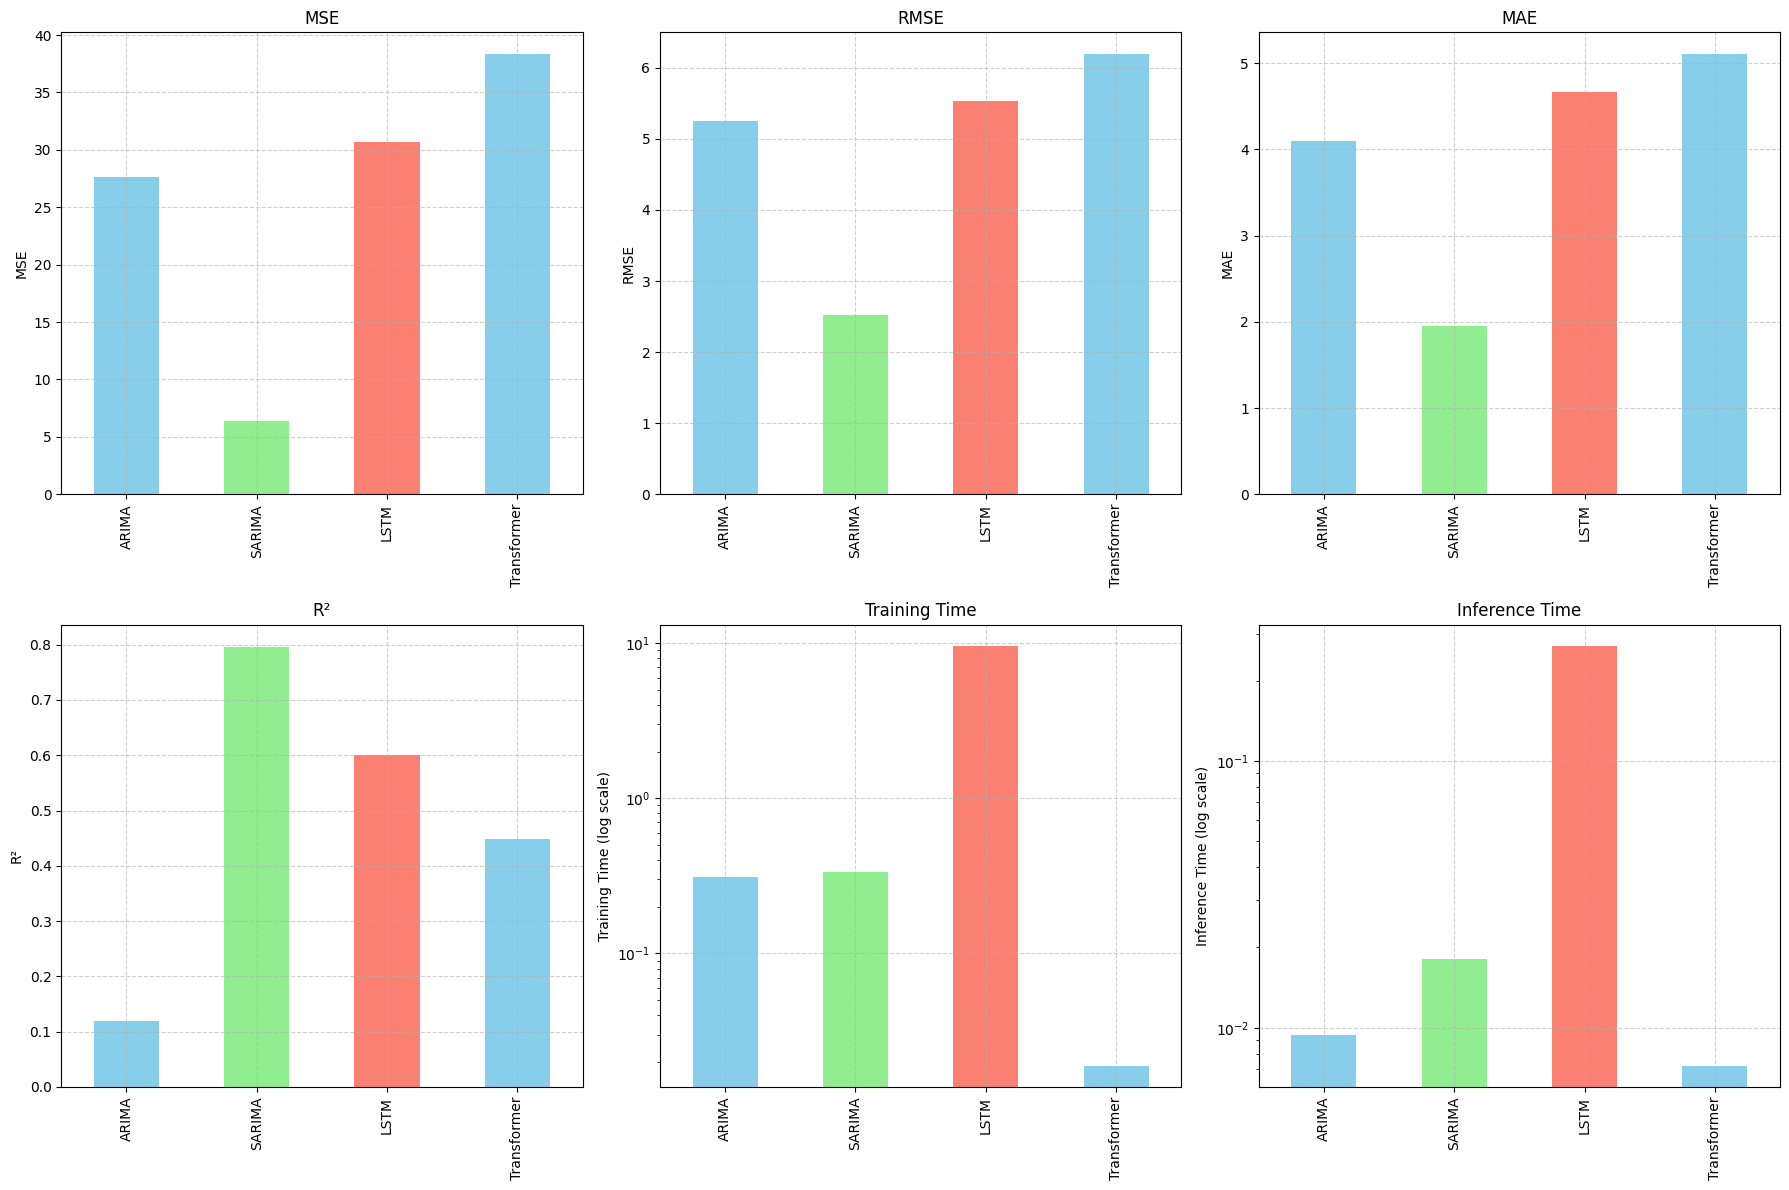

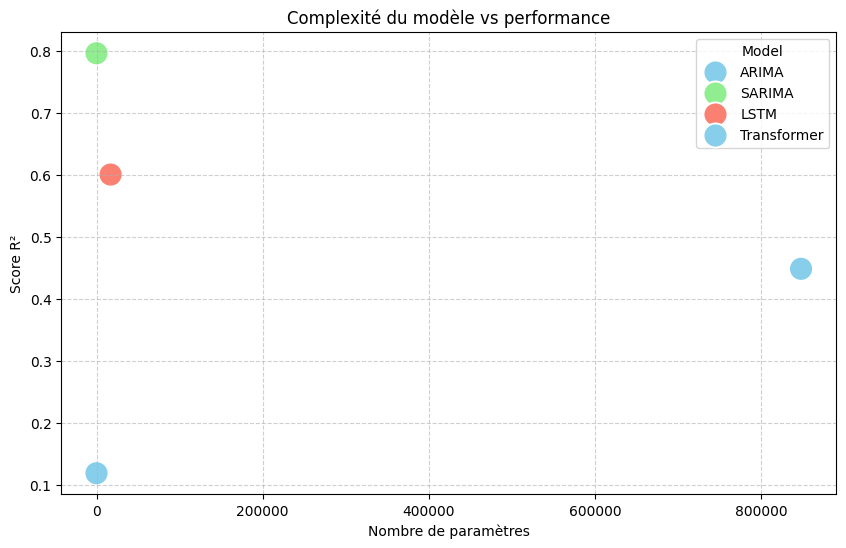

In [82]:
# Les mertiques de tous les modèles
metrics = {
    'ARIMA': {
        'MSE': mse_test_arima,
        'RMSE': rmse_test_arima,
        'MAE': mae_test_arima,
        'R²': r2_test_arima,
        'Training Time': training_time_arima,
        'Inference Time': inference_time_arima,
        'Parameters': arima_par
    },
    'SARIMA': {
        'MSE': mse_test_sarima,
        'RMSE': rmse_test_sarima,
        'MAE': mae_test_sarima,
        'R²': r2_test_sarima,
        'Training Time': training_time_sarima,
        'Inference Time': inference_time_sarima,
        'Parameters': sarima_par
    },
    'LSTM': {
        'MSE': mse_test_lstm,
        'RMSE': rmse_test_lstm,
        'MAE': mae_test_lstm,
        'R²': r2_test_lstm,
        'Training Time': training_time_lstm,
        'Inference Time': inference_time_lstm,
        'Parameters': lstm_par
    },
    'Transformer': {
    'MSE': mse_test_trans,
    'RMSE': rmse_test_trans,
    'MAE': mae_test_trans,
    'R²': r2_test_trans,
    'Training Time': training_time_trans,
    'Inference Time': inference_time_trans,
    'Parameters': trans_par
}
}

# Créer un DataFrame de comparaison

df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
print("\nComparaison de modèles")
print(df_metrics)


# Visualizations

# Créer des subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
metrics_to_plot = ['MSE', 'RMSE', 'MAE', 'R²', 'Training Time', 'Inference Time']

for i, metric in enumerate(metrics_to_plot):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Bar plot for each metric
    df_metrics[metric].plot(kind='bar', ax=ax, color=['skyblue', 'lightgreen', 'salmon'])
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Special handling for time metrics
    if metric in ['Training Time', 'Inference Time']:
        ax.set_yscale('log')
        ax.set_ylabel(f'{metric} (log scale)')

plt.tight_layout()
plt.show()

# Visualisation des paramètres par rapport aux performances
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_metrics, x='Parameters', y='R²', hue=df_metrics.index, 
                s=300, palette=['skyblue', 'lightgreen', 'salmon'])
plt.title('Complexité du modèle vs performance')
plt.xlabel('Nombre de paramètres')
plt.ylabel('Score R²')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Model')
plt.show()

**Analyse:**
- MSE (Mean Squared Error) : Le LSTM affiche l'erreur la plus élevée (~35) et Transformer à ~ (39), tandis que SARIMA présente la meilleure performance (~6). ARIMA se situe à (~27).
- RMSE (Root Mean Squared Error) : Le Transformer montre encore la pire performance (~6.3) LSTM est intermédiaire (~5.9), suivi par ARIMA (~5.2). SARIMA est le meilleur (~2.5).
- MAE (Mean Absolute Error) : Même tendance avec Transformer à (~5.2), LSTM montrant l'erreur (~4.8) et SARIMA la plus basse (~2). ARIMA est à (~4.1).
- R² : SARIMA offre la meilleure (~0.8). LSTM est moyen (~0.55), Transformer (~0.45), et ARIMA est très faible (~0.12).
- Temps d'entraînement (échelle logarithmique) : LSTM prend significativement plus de temps (~10¹), tandis que Transformer est le plus rapide (~0.01). ARIMA et SARIMA sont comparables (~0.3).
- Temps d'inférence (échelle logarithmique) : LSTM est encore le plus lent (~10⁰), ARIMA et SARIMA sont rapides (~0.04) et Transformer suit très rapides (~0.007).

-------

- SARIMA : Offre le meilleur R² (~0.8) avec très peu de paramètres (proche de 0)
- LSTM : Performance moyenne (R² ~0.55) avec peu de paramètres
- Transformer : Performance moyenne R² (~0.45) avec une haute complexité (~800,000 paramètres)
- ARIMA : Performance faible (R² ~0.12) avec très peu de paramètres

-------

En résumé, SARIMA semble offrir le meilleur compromis entre précision et simplicité.